# Análisis Encuesta Origen-Destino -  Limpieza de Datos & Cálculo de Indicadores

## Colombia - Bogotá - 2019

#### Elaborado por Paula Vásquez-Henríquez, Ariel López, Genaro Cuadros, Exequiel Gaete, Alba Vásquez y Juan Correa

In [ ]:
!pip3 uninstall matplotlib -y

Found existing installation: matplotlib 3.2.2
Uninstalling matplotlib-3.2.2:
  Successfully uninstalled matplotlib-3.2.2


In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:45
🔁 Restarting kernel...


In [ ]:
!git clone https://github.com/zorzalerrante/aves.git aves_git

Cloning into 'aves_git'...
remote: Enumerating objects: 832, done.
remote: Counting objects: 100% (463/463), done.
remote: Compressing objects: 100% (224/224), done.
remote: Total 832 (delta 200), reused 435 (delta 183), pack-reused 369
Receiving objects: 100% (832/832), 165.53 MiB | 24.46 MiB/s, done.
Resolving deltas: 100% (323/323), done.
Checking out files: 100% (280/280), done.


In [ ]:
!mamba env update --name base --file aves_git/environment-colab.yml

pkgs/main/linux-64       [] (00m:00s) 
pkgs/main/linux-64       [] (00m:00s) 51 KB / ?? (337.92 KB/s)
pkgs/main/linux-64       [] (00m:00s) 51 KB / ?? (337.92 KB/s)
pkgs/main/noarch         [] (00m:00s) 
pkgs/main/linux-64       [] (00m:00s) 51 KB / ?? (337.92 KB/s)
pkgs/main/noarch         [] (00m:00s) 248 KB / ?? (1.61 MB/s)
pkgs/main/linux-64       [] (00m:00s) 51 KB / ?? (337.92 KB/s)
pkgs/main/noarch         [] (00m:00s) 248 KB / ?? (1.61 MB/s)
pkgs/r/linux-64          [] (00m:00s) 
pkgs/main/linux-64       [] (00m:00s) 51 KB / ?? (337.92 KB/s)
pkgs/main/noarch         [] (00m:00s) 248 KB / ?? (1.61 MB/s)
pkgs/r/linux-64          [] (00m:00s) 116 KB / ?? (773.40 KB/s)
pkgs/main/linux-64       [] (00m:00s) 51 KB / ?? (337.92 KB/s)
pkgs/main/noarch         [] (00m:00s) Finalizing...
pkgs/r/linux-64          [] (00m:00s) 116 KB / ?? (773.40 KB/s)
pkgs/main/linux-64       [] (00m:00s) 51 KB / ?? (337.92 KB/s)
pkgs/main/noarch         [] (00m:00s) Done
pkgs/r/linux-64          [] (00m:

In [ ]:
!pip3 install geopandas
!pip3 install haversine
!pip3 install pandasql
!pip3 install seaborn

     |████████████████████████████████| 1.6 MB 5.9 MB/s 
     |████████████████████████████████| 150 kB 52.2 MB/s 
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26818 sha256=6c3bc618b0407e6447918a04c544775f625ed31cb24362c6bd1628a8ac35d627
  Stored in directory: /root/.cache/pip/wheels/5c/4b/ec/41f4e116c8053c3654e2c2a47c62b4fca34cc67ef7b55deb7f
Successfully built pandasql


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import geopandas as gpd
import warnings
import haversine as hs
import shapely
from sklearn.preprocessing import normalize
import datetime

In [ ]:
def convert_datatype(df, lista_columnas):
    for column in lista_columnas:
        df[column] = df[column].str.replace(",", ".").astype(float)
    return df

In [ ]:
def decode_column(df, fname, col_name, index_col='id', value_col=None, sep=';', encoding='utf-8'):
    '''
    param :df: DataFrame del que leeremos una columna.
    param :fname: nombre del archivo que contiene los valores a decodificar.
    param :col_name: nombre de la columna que queremos decodificar.
    param :index_col: nombre de la columna en el archivo @fname que tiene los índices que codifican @col_name
    param :value_col: nombre de la columna en el archivo @fname que tiene los valores decodificados
    param :sep: carácter que separa los valores en @fname. 
    param :encoding: identificación del _character set_ que utiliza el archivo. Usualmente es utf-8, si no funciona,
                     se puede probar con iso-8859-1.
    '''
    if value_col is None:
        value_col = 'value'
        
    values_df = pd.read_csv(fname, sep=sep, index_col=index_col, names=[index_col, value_col], header=0,
                            dtype={index_col: np.float64}, encoding=encoding)
    
    src_df = df.loc[:,(col_name,)]
    
    return src_df.join(values_df, on=col_name)[value_col]

In [ ]:
def imputar_coordenadas_centroide_zat(df, latitud, longitud, zat, zona_shp):
    columns = df.columns
    df['mask'] = df[latitud].isnull() | df[longitud].isnull()
    working_df = pd.merge(df, city_shp[[zona_shp, 'x_coord', 'y_coord']], left_on=zat, right_on=zona_shp, how='left')
    working_df[latitud] = np.where(working_df['mask']==True, working_df['y_coord'], working_df[latitud])
    working_df[longitud] = np.where(working_df['mask']==True, working_df['x_coord'], working_df[longitud])
    
    return working_df[columns]

In [ ]:
def mapear_binarias(row, column):
    if row[column] == 'N':
        return 'No'
    elif row[column] == 'S':
        return 'Si'
    else:
        return 'Sin dato'

In [ ]:
def haversine(coord1, coord2):
    R = 6372800  # Earth radius in meters
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    
    phi1, phi2 = math.radians(lat1), math.radians(lat2) 
    dphi       = math.radians(lat2 - lat1)
    dlambda    = math.radians(lon2 - lon1)
    
    a = math.sin(dphi/2)**2 + \
        math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    
    return 2*R*math.atan2(math.sqrt(a), math.sqrt(1 - a))

In [ ]:
def mapear_vacios(row, column):
    if pd.isna(row[column])==True:
        return 'Sin informacion'
    else:
        return row[column]

In [ ]:
def age_cohorts(row, age_column):
    if row[age_column] < 18:
        return '<18'
    elif row[age_column] <=29 and row[age_column] > 18:
        return '18-29'
    elif row[age_column] <=60 and row[age_column] > 29:
        return '30-60'
    elif row[age_column] > 60 and row[age_column] < 100:
        return '>60'
    else:
        return 'No declarado'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Caracterización de los datos

Los datos utilizados en este cuaderno corresponden a los resultados de la Encuesta Origen-Destino de Bogotá, Colombia del 2019. 
A partir de estos datos se calcularan indicadores en tres niveles: de Cantidad de Viajes, de Tiempo de Viajes, y de Distancia de Viajes.

### Importando datos

En esta sección, importamos todos los datos necesarios para el cálculo de indicadores. 
Para el caso de Bogotá 2019, los archivos son de Excel.

Cabe destacar que para esta EOD tenemos data a nivel de:
- Viajes
- Etapas
- Personas
- Hogares

In [ ]:
data_path = '/content/drive/MyDrive/Carpeta compartida (clon Teams)/Ciudades/Bogotá/EOD_Bogota/Encuesta de Movilidad 2019'
#data_path = '/Users/pauvasquezh/Dropbox/Proyectos/eod_analysis/Carpeta compartida (clon Teams)/Bogotá/EOD_Bogota/Encuesta de Movilidad 2019'

In [ ]:
# Matriz de viajes
data_viajes = pd.read_excel(data_path + '/BD EODH2019 FINAL v14022020/Archivos XLSX/ViajesEODH2019.xlsx')
#data_viajes = convert_datatype(data_viajes, ["LATITUD_ORIGEN", "LATITUD_DESTINO", "LONGITUD_ORIGEN", "LONGITUD_DESTINO", 'PONDERADOR_CALIBRADO_VIAJES', 'FE_TOTAL', 'FACTOR_AJUSTE_TRANSMILENIO', 'PONDERADOR_CALIBRADO'])

In [ ]:
# Matriz de personas
data_personas = pd.read_excel(data_path + '/BD EODH2019 FINAL v14022020/Archivos XLSX/PersonasEODH2019.xlsx')

In [ ]:
# Matriz de hogares
data_encuestas = pd.read_excel(data_path + '/BD EODH2019 FINAL v14022020/Archivos XLSX/HogaresEODH2019.xlsx')

In [ ]:
# Matriz de etapas
data_etapas = pd.read_excel(data_path + '/BD EODH2019 FINAL v14022020/Archivos XLSX/EtapasEODH2019.xlsx')

In [ ]:
# Shapefile de la ciudad, calculamos centroide del zat
city_shp = gpd.read_file(data_path + "/Zonificación (shapefiles)/ZONAS/ZAT.shp")


In [ ]:
city_shp.crs

<Geographic 2D CRS: EPSG:4686>
Name: MAGNA-SIRGAS
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Colombia - onshore and offshore. Includes San Andres y Providencia, Malpelo Islands, Roncador Bank, Serrana Bank and Serranilla Bank.
- bounds: (-84.77, -4.23, -66.87, 15.51)
Datum: Marco Geocentrico Nacional de Referencia
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [ ]:
centroid = city_shp['geometry'].centroid

city_shp['x_coord'] = centroid.x
city_shp['y_coord'] = centroid.y

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.


### Preparación de los datos

#### Viajes

En esta etapa nos enfocaremos en preparar los datos con respecto a viajes.
En particular, nos enfocamos en limpiar y estandarizar los datos para las columnas que son relevantes para el cálculo de indicadores.


In [ ]:
selected_columns = ['id_hogar', 'id_persona', 'id_viaje', 
       'zat_origen', 'p17_Id_motivo_viaje', 'p17_otro_motivo',
       'hora_inicio_viaje', 'zat_destino',
       'p31_hora_llegada', 'fecha',
       'f_exp', 'mun_origen', 'mun_destino', 'utam_origen',
       'utam_destino', 'modo_principal', 'modo_principal_desagregado']
viajes_df = data_viajes[selected_columns]

In [ ]:
viajes_df.shape

(134497, 17)

In [ ]:
print('Contando valores nulos por atributo')
for column in viajes_df.columns:
    print('{}: {}'.format(column, viajes_df[column].isna().sum()))

Contando valores nulos por atributo
id_hogar: 0
id_persona: 0
id_viaje: 0
zat_origen: 7134
p17_Id_motivo_viaje: 0
p17_otro_motivo: 133993
hora_inicio_viaje: 0
zat_destino: 7136
p31_hora_llegada: 0
fecha: 7133
f_exp: 0
mun_origen: 7281
mun_destino: 7231
utam_origen: 9264
utam_destino: 9209
modo_principal: 0
modo_principal_desagregado: 0


In [ ]:
# Generamos un identificador unico de viaje

In [ ]:
viajes_df['id_viaje_u'] = viajes_df['id_hogar'].astype(str) + viajes_df['id_persona'].astype(str)+ viajes_df['id_viaje'].astype(str)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
# Decodificando motivo de viaje
viajes_df.p17_Id_motivo_viaje = decode_column(viajes_df, data_path + '/data_dictionaries/trip_purpose.csv', 'p17_Id_motivo_viaje')

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
# Nos quedamos solo con los viajes que tienen información de origen y destino
mask = viajes_df['zat_origen'].isnull() | viajes_df['zat_destino'].isnull()
viajes_df = viajes_df[~mask]
viajes_df = viajes_df[(viajes_df.zat_destino>0) & (viajes_df.zat_origen>0)]

In [ ]:
viajes_df['LATITUD_ORIGEN'] = None
viajes_df['LONGITUD_ORIGEN'] = None
viajes_df['LATITUD_DESTINO'] = None
viajes_df['LONGITUD_DESTINO'] = None

In [ ]:
# Como no tenemos info de coordenadas, imputamos a cada viaje el centroide del ZAT de origen y destino
viajes_df = imputar_coordenadas_centroide_zat(viajes_df, 'LATITUD_ORIGEN', 'LONGITUD_ORIGEN', 'zat_origen', 'ZAT')
viajes_df = imputar_coordenadas_centroide_zat(viajes_df, 'LATITUD_DESTINO', 'LONGITUD_DESTINO','zat_destino', 'ZAT')

In [ ]:
# Obtenemos dia de la semana del viaje

In [ ]:
viajes_df['fecha'] = pd.to_datetime(viajes_df['fecha']) - pd.Timedelta(days=1)

viajes_df['day_of_week'] = viajes_df['fecha'].dt.day_name()

In [ ]:
habil=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
nohabil=['Saturday', 'Sunday']

In [ ]:
#columns_day = ['DIA_HABIL', 'DIA_NOHABIL', 'PICO_HABIL', 'PICO_NOHABIL']
def dia_habil(row):
    if row['day_of_week'] in habil:
        return 'Si'
    else:
        return 'No'

def dia_nohabil(row):
    if row['day_of_week'] in nohabil:
        return 'Si'
    else:
        return 'No'

In [ ]:
# Clasificamos segun dia de la semana
viajes_df['DIA_HABIL'] = viajes_df.apply(lambda row: dia_habil(row), axis=1)
viajes_df['DIA_NOHABIL'] = viajes_df.apply(lambda row: dia_nohabil(row), axis=1)

In [ ]:
# Clasificamos cada viaje como intra o interzonal
viajes_df['Intra_Inter'] = viajes_df.apply(lambda row: 'Intra' if row['zat_origen'] == row['zat_destino'] else 'Inter', axis=1)

In [ ]:
viajes_df.modo_principal.unique()

array(['SITP Provisional', 'Transporte informal', 'SITP Zonal', 'A pie',
       'Bicicleta', 'Auto', 'Moto', 'Transporte Escolar', 'TransMilenio',
       'Otro', 'Transporte publico individual', 'Alimentador',
       'Intermunicipal', 'Bicitaxi', 'Patineta', 'Cable'], dtype=object)

In [ ]:
# Definimos etiquetas de público o privado
publico_viaje = ['TransMilenio', 'Alimentador', 'SITP Zonal', 'SITP Provisional', 'Intermunicipal', 'Cable', 'Transporte publico individual']
privado_viaje = ['Moto', 'Auto', 'A pie', 'Bicicleta', 'Transporte Escolar', 'Bicitaxi', 'Patineta']
peaton_viaje = ['A pie', 'Bicicleta', 'Patineta', 'Bicitaxi']
motorizado_viaje = ['TransMilenio', 'Alimentador', 'SITP Zonal', 'SITP Provisional', 'Intermunicipal', 'Transporte publico individual','Moto', 'Auto', 'Transporte Escolar']

In [ ]:
# Clasificando los viajes como públicos o privados según medio
def publico_privado(row, column, publico, privado):
    if row[column] in (publico):
        return 'Público'
    elif row[column] in (privado):
        return 'Privado'
    else:
        return 'Otro'
    
viajes_df['publico_privado'] = viajes_df.apply(lambda row: publico_privado(row, 'modo_principal', publico_viaje, privado_viaje), axis=1)

In [ ]:
# Clasificando los viajes como públicos o privados según medio
def motorizado(row, column, no_motorizado, motorizado):
    if row[column] in (motorizado):
        return 'Motorizado'
    elif row[column] in (no_motorizado):
        return 'No Motorizado'
    else:
        return 'Otro'
    
viajes_df['motorizado'] = viajes_df.apply(lambda row: motorizado(row, 'modo_principal', peaton_viaje,motorizado_viaje), axis=1)

In [ ]:
# Calculamos hora de salida y llegada
viajes_df['hora_inicio_viaje'] = viajes_df.hora_inicio_viaje.astype(str).str.split(':').map(lambda x: pd.Timedelta(hours=int(x[0]), minutes=int(x[1])))
viajes_df['p31_hora_llegada'] = viajes_df.p31_hora_llegada.astype(str).str.split(':').map(lambda x: pd.Timedelta(hours=int(x[0]), minutes=int(x[1])))

In [ ]:
viajes_df['p31_hora_llegada'][viajes_df['p31_hora_llegada'] < viajes_df['hora_inicio_viaje']] = viajes_df['p31_hora_llegada'][viajes_df['p31_hora_llegada'] < viajes_df['hora_inicio_viaje']] + pd.Timedelta(days=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
# Obtenemos duración del viaje
viajes_df['duracion'] = (viajes_df['p31_hora_llegada'] - viajes_df['hora_inicio_viaje'])

In [ ]:
viajes_df['hora_inicio_viaje_aux'] = viajes_df['hora_inicio_viaje'] / np.timedelta64(1, 'h')

In [ ]:
# Asignamos etiquetas de viaje en horario pico para dia habil y no habil
def pico_habil(row):
    if ((row['hora_inicio_viaje_aux'] >= 6 and row['hora_inicio_viaje_aux'] <= 7) or (row['hora_inicio_viaje_aux'] >= 12 and row['hora_inicio_viaje_aux'] < 13) or (row['hora_inicio_viaje_aux'] >= 5 and row['hora_inicio_viaje_aux'] <= 6)) and row['DIA_HABIL']=='Si':
        return'Si'
    else:
        return 'No'
    
viajes_df['PICO_HABIL'] = viajes_df.apply(lambda row: pico_habil(row), axis=1)

In [ ]:
def pico_nohabil(row):
    if ((row['hora_inicio_viaje_aux'] >= 6 and row['hora_inicio_viaje_aux'] <= 7) or (row['hora_inicio_viaje_aux'] >= 12 and row['hora_inicio_viaje_aux'] < 13) or (row['hora_inicio_viaje_aux'] >= 5 and row['hora_inicio_viaje_aux'] <= 6)) and row['DIA_NOHABIL']=='Si':
        return'Si'
    else:
        return 'No'
    
viajes_df['PICO_NOHABIL'] = viajes_df.apply(lambda row: pico_nohabil(row), axis=1)

In [ ]:
import math
def haversine(coord1, coord2):
    R = 6372800  # Earth radius in meters
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    
    phi1, phi2 = math.radians(lat1), math.radians(lat2) 
    dphi       = math.radians(lat2 - lat1)
    dlambda    = math.radians(lon2 - lon1)
    
    a = math.sin(dphi/2)**2 + \
        math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    
    return 2*R*math.atan2(math.sqrt(a), math.sqrt(1 - a))

In [ ]:
# Calculamos distancia (en este caso haversine por la proyección del shapefile)
viajes_df['distancia_manhattan'] = viajes_df.apply(lambda row: haversine(np.array([row['LATITUD_ORIGEN'], row['LONGITUD_ORIGEN']]), np.array([row['LATITUD_DESTINO'], row['LONGITUD_DESTINO']])), axis=1)

In [ ]:
print('Contando valores nulos por atributo')
for column in viajes_df.columns:
    print('{}: {}'.format(column, viajes_df[column].isna().sum()))

Contando valores nulos por atributo
id_hogar: 0
id_persona: 0
id_viaje: 0
zat_origen: 0
p17_Id_motivo_viaje: 1
p17_otro_motivo: 126327
hora_inicio_viaje: 0
zat_destino: 0
p31_hora_llegada: 0
fecha: 0
f_exp: 0
mun_origen: 1
mun_destino: 0
utam_origen: 1975
utam_destino: 1967
modo_principal: 0
modo_principal_desagregado: 0
id_viaje_u: 0
LATITUD_ORIGEN: 1
LONGITUD_ORIGEN: 1
LATITUD_DESTINO: 0
LONGITUD_DESTINO: 0
day_of_week: 0
DIA_HABIL: 0
DIA_NOHABIL: 0
Intra_Inter: 0
publico_privado: 0
motorizado: 0
duracion: 0
hora_inicio_viaje_aux: 0
PICO_HABIL: 0
PICO_NOHABIL: 0
distancia_manhattan: 1


In [ ]:
viajes_df.shape

(126800, 33)

#### Personas y Hogares

En esta etapa nos enfocaremos en preparar los datos con respecto a personas.
En particular, nos enfocamos en limpiar y estandarizar los datos para las columnas que son relevantes para el cálculo de indicadores.

In [ ]:
data_encuestas.id_rango_ingresos = decode_column(data_encuestas, data_path + '/data_dictionaries/tramo.csv', 'id_rango_ingresos')
data_personas.p6_id_ocupacion = decode_column(data_personas, data_path + '/data_dictionaries/occupations.csv', 'p6_id_ocupacion')

In [ ]:
selected_columns = ['id_hogar', 'id_persona', 'Sexo', 'f_exp', 'p4_edad', 'p6_id_ocupacion']
personas_df = data_personas[selected_columns]

In [ ]:
selected_columns = ['Id_Hogar', 'id_rango_ingresos', 'p5_estrato', 'p7_Barrio_vivienda']
encuestas_df = data_encuestas[selected_columns]

In [ ]:
personas_df = pd.merge(personas_df, encuestas_df, left_on='id_hogar', right_on='Id_Hogar', how='left')

In [ ]:
personas_df['id_rango_ingresos'] = personas_df.apply(lambda row: mapear_vacios(row, 'id_rango_ingresos'), axis=1)

In [ ]:
personas_df['id_persona_u'] = personas_df['id_hogar'].astype(str) + personas_df['id_persona'].astype(str)

In [ ]:
viajes_personas = pd.merge(viajes_df, personas_df, on=['id_hogar', 'id_persona'], how='inner')

In [ ]:
print('Contando valores nulos por atributo')
for column in viajes_personas.columns:
    print('{}: {}'.format(column, viajes_personas[column].isna().sum()))

Contando valores nulos por atributo
id_hogar: 0
id_persona: 0
id_viaje: 0
zat_origen: 0
p17_Id_motivo_viaje: 1
p17_otro_motivo: 126327
hora_inicio_viaje: 0
zat_destino: 0
p31_hora_llegada: 0
fecha: 0
f_exp_x: 0
mun_origen: 1
mun_destino: 0
utam_origen: 1975
utam_destino: 1967
modo_principal: 0
modo_principal_desagregado: 0
id_viaje_u: 0
LATITUD_ORIGEN: 1
LONGITUD_ORIGEN: 1
LATITUD_DESTINO: 0
LONGITUD_DESTINO: 0
day_of_week: 0
DIA_HABIL: 0
DIA_NOHABIL: 0
Intra_Inter: 0
publico_privado: 0
motorizado: 0
duracion: 0
hora_inicio_viaje_aux: 0
PICO_HABIL: 0
PICO_NOHABIL: 0
distancia_manhattan: 1
Sexo: 0
f_exp_y: 0
p4_edad: 0
p6_id_ocupacion: 1700
Id_Hogar: 0
id_rango_ingresos: 0
p5_estrato: 0
p7_Barrio_vivienda: 0
id_persona_u: 0


In [ ]:
viajes_personas.to_csv(data_path + '/viajes_personas_bogota_2019.csv', index=False)

### Descripción de los datos

¿Dónde viven los encuestados?

In [ ]:
encuestas_df = encuestas_df[encuestas_df.p7_Barrio_vivienda!=datetime.datetime(2020, 8, 7, 0, 0)]
encuestas_df = encuestas_df[encuestas_df.p7_Barrio_vivienda!=datetime.datetime(2020, 7, 20, 0, 0)]

/usr/local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 141 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 141 missing from current font.
  font.set_text(s, 0, flags=flags)


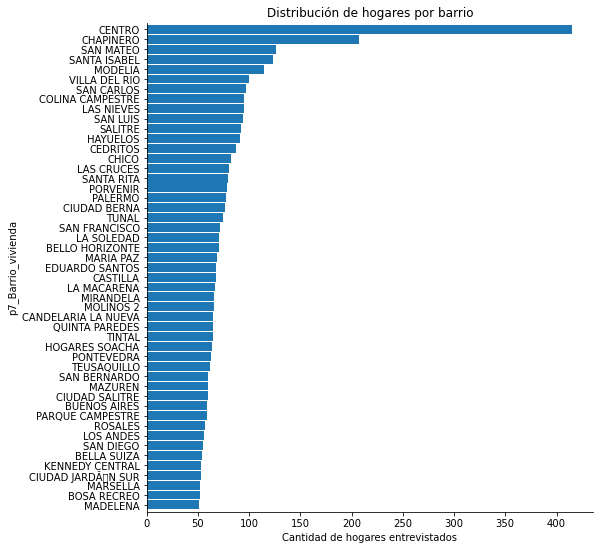

In [ ]:
hogares_por_barrio = encuestas_df.groupby("p7_Barrio_vivienda").size().sort_values()

ax = hogares_por_barrio[-49:].plot(kind="barh", width=0.9, figsize=(8, 9))
ax.set_xlabel("Cantidad de hogares entrevistados")
ax.set_title("Distribución de hogares por barrio")
sns.despine()

Vemos que la mayor parte de los hogares encuestados se encuentran en la zona centro.

¿Quienes son las personas encuestadas?

In [ ]:
personas_df.p4_edad.describe()

count    63245.000000
mean        38.291818
std         44.714678
min          5.000000
25%         21.000000
50%         36.000000
75%         54.000000
max       9999.000000
Name: p4_edad, dtype: float64

In [ ]:
personas_df['age_cohort'] = personas_df.apply(lambda row: age_cohorts(row, 'p4_edad'), axis=1)

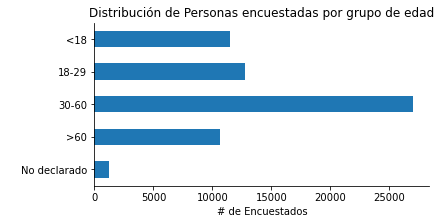

In [ ]:
order = ['<18', '18-29', '30-60','>60','No declarado']
ax = (personas_df.groupby(['age_cohort']).size().loc[reversed(order)]
 .plot(kind='barh', figsize=(6,3)))
ax.set_xlabel("# de Encuestados")
ax.set_ylabel(" ")
ax.set_title("Distribución de Personas encuestadas por grupo de edad")
sns.despine()

La mayor parte de los encuestados tiene entre 30 y 60 años de edad.

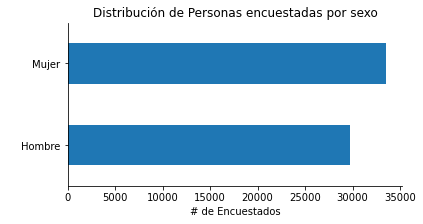

In [ ]:
ax = (personas_df.groupby(['Sexo']).size()
 .plot(kind='barh', figsize=(6,3)))
ax.set_xlabel("# de Encuestados")
ax.set_ylabel(" ")
ax.set_title("Distribución de Personas encuestadas por sexo")
sns.despine()


In [ ]:
def normalize_rows(df):
    return df.pipe(lambda x: pd.DataFrame(normalize(df, axis=1, norm='l1'), columns=df.columns, index=df.index))

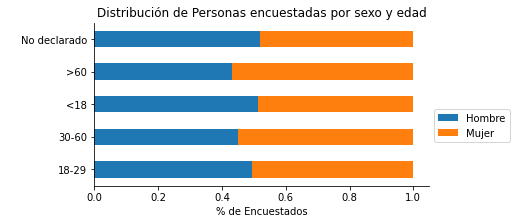

In [ ]:
ax = (personas_df.groupby(['age_cohort', 'Sexo']).size().unstack()
 .pipe(normalize_rows)
 .plot(kind='barh', stacked=True, figsize=(6, 3)))
ax.set_xlabel("% de Encuestados")
ax.set_ylabel(" ")
ax.set_title("Distribución de Personas encuestadas por sexo y edad")
sns.despine()

plt.legend(loc=0, bbox_to_anchor=(1.0, 0.5))

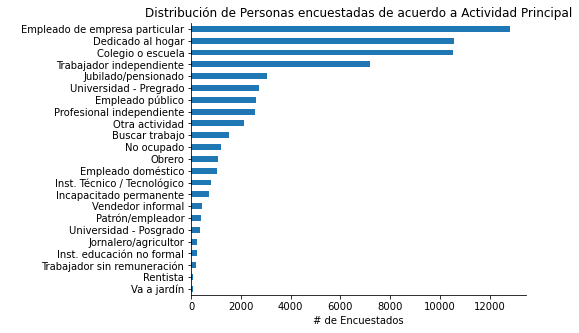

In [ ]:
ax = (personas_df.groupby(['p6_id_ocupacion']).size().sort_values()
 .plot(kind='barh', figsize=(6,5)))
ax.set_xlabel("# de Encuestados")
ax.set_ylabel(" ")
ax.set_title("Distribución de Personas encuestadas de acuerdo a Actividad Principal")
sns.despine()

### Parte I: Indicadores de Cantidad de Viajes

En esta primera parte, responderemos algunas preguntas respecto a indicadores de cantidades de viajes realizados, en días hábiles y no hábiles de viaje. Para esto, buscaremos responder las siguientes preguntas:

1. ¿Cuál es la tasa promedio de viajes diarios en transporte público por clasificador económico?
2. ¿Cuál es la tasa promedio de viajes diarios en transporte privado por clasificador económico?
3. ¿Cuál es la razón entre los viajes en transporte público y privado por clasificador socioeconómico?
4. ¿Cuál es la distribución/partición modal de los viajes por clasificador socioeconómico?

En esta sección, se detallarán los resultados para indicadores a nivel de viajes, separados por días hábiles y no hábiles de viaje, y por clasificador socioeconómico.

In [ ]:
viajes_personas = viajes_personas.drop(['Id_Hogar'], axis=1)

In [ ]:
print('Cantidad de viajes mapeados: totales encuesta , total expandido')
viajes_habiles = viajes_personas[viajes_personas.DIA_HABIL=='Si']
print('Total Viajes Habiles: {}'.format(viajes_habiles.shape[0]), viajes_habiles['f_exp_x'].sum())
viajes_nohabiles = viajes_personas[viajes_personas.DIA_NOHABIL=='Si']
print('Total Viajes No Habiles: {}'.format(viajes_nohabiles.shape[0]), viajes_nohabiles['f_exp_x'].sum())

Cantidad de viajes mapeados: totales encuesta , total expandido
Total Viajes Habiles: 108131 15400135.662010366
Total Viajes No Habiles: 18669 2369661.6637615776


Separamos los viajes habiles y no habiles de acuerdo a si son privados o publicos

In [ ]:
viajes_publico_habiles = viajes_habiles[viajes_habiles.modo_principal.isin(publico_viaje)]
viajes_publico_nohabiles = viajes_nohabiles[viajes_nohabiles.modo_principal.isin(publico_viaje)]

viajes_privado_habiles = viajes_habiles[viajes_habiles.modo_principal.isin(privado_viaje)]
viajes_privado_nohabiles = viajes_nohabiles[viajes_nohabiles.modo_principal.isin(privado_viaje)]

In [ ]:
def weighted_mean(df, value_column, weighs_column):
    weighted_sum = (df[value_column] * df[weighs_column]).sum()
    return weighted_sum / df[weighs_column].sum()

In [ ]:
from pandasql import sqldf
def calculate_n_viajes_per_capita(df, df_str, agg_columns_str, agg_columns_lst, id_person, person_weight, trip_weight=None):
    q = "SELECT DISTINCT {}, {}, {} FROM {}".format(id_person, agg_columns_str, person_weight, df_str)
    persons = sqldf(q, globals())
    n_personas = persons.groupby(agg_columns_lst).sum()[[person_weight]].reset_index()
    n_personas[agg_columns_lst[0]] = n_personas[agg_columns_lst[0]].astype(str)
    n_viajes = df.groupby(agg_columns_lst).sum()[[trip_weight]].reset_index()
    n_viajes[agg_columns_lst[0]] = n_viajes[agg_columns_lst[0]].astype(str)
    merged = pd.merge(n_personas, n_viajes, on=agg_columns_lst, how='left')
    merged['viajes_per_capita'] = merged[trip_weight] / merged[person_weight]
    return merged

#### **¿Cuál es la tasa promedio de viajes diarios en transporte público por clasificador económico?**

Los siguientes gráficos muestran los viajes per cápita en trasporte público durante días hábiles y no hábiles, por clasificador socioeconómico.

In [ ]:
print('Viajes per cápita en transporte público - Día Hábil')
df = calculate_n_viajes_per_capita(viajes_publico_habiles, "viajes_publico_habiles", "id_rango_ingresos", ["id_rango_ingresos"], 'id_persona_u', 'f_exp_y', 'f_exp_x')

Viajes per cápita en transporte público - Día Hábil


/usr/local/lib/python3.7/site-packages/pandasql/sqldf.py:121: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  index=not any(name is None for name in df.index.names))  # load index into db if all levels are named


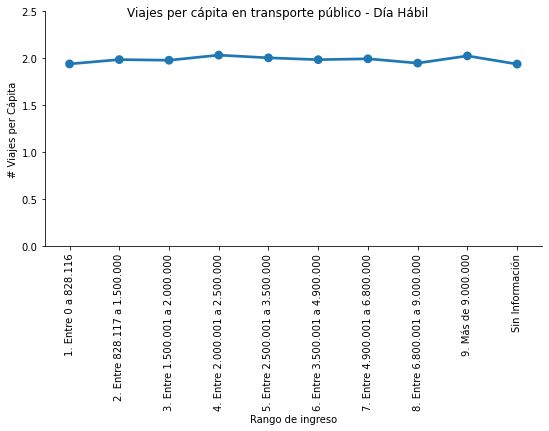

In [ ]:
g = sns.catplot(x="id_rango_ingresos", y="viajes_per_capita", 
                capsize=.2, height=4, aspect=2,
                kind="point", data=df)

g.fig.suptitle('Viajes per cápita en transporte público - Día Hábil')
g.set_ylabels('# Viajes per Cápita')
g.set_xlabels('Rango de ingreso')
g.set_xticklabels(rotation=90)
g.set(ylim=(0,2.5))

fig.tight_layout()

In [ ]:
print('Viajes per cápita en transporte público - Día No Hábil')
df = calculate_n_viajes_per_capita(viajes_publico_nohabiles, "viajes_publico_nohabiles", "id_rango_ingresos", ["id_rango_ingresos"], 'id_persona_u', 'f_exp_y', 'f_exp_x')

Viajes per cápita en transporte público - Día No Hábil


/usr/local/lib/python3.7/site-packages/pandasql/sqldf.py:121: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  index=not any(name is None for name in df.index.names))  # load index into db if all levels are named


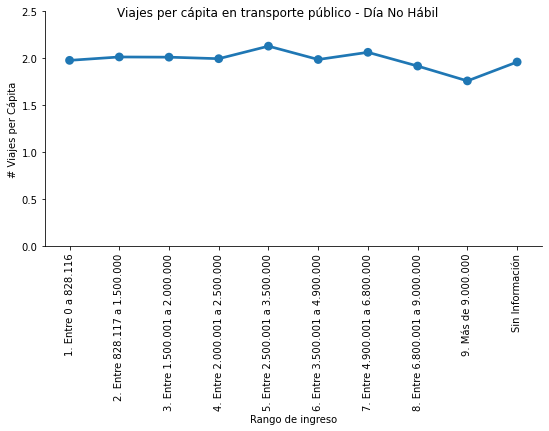

In [ ]:
g = sns.catplot(x="id_rango_ingresos", y="viajes_per_capita", 
                capsize=.2, height=4, aspect=2,
                kind="point", data=df)

g.fig.suptitle('Viajes per cápita en transporte público - Día No Hábil')
g.set_ylabels('# Viajes per Cápita')
g.set_xlabels('Rango de ingreso')
g.set_xticklabels(rotation=90)
g.set(ylim=(0,2.5))

fig.tight_layout()

Durante días hábiles, no se ve una diferencia a través de los rangos de ingreso de viajes per cápita en transporte público. Durante días hábiles, se ve una tendencia similar con una disminución en los dos tramos con ingresos más altos.

#### **¿Cuál es la tasa promedio de viajes diarios en transporte privado por clasificador económico?**

Los siguientes gráficos representan la tasa promedio de viajes diarios en el transporte privado durante días hábiles y no hábiles, por clasificador socioeconómico.

In [ ]:
print('Viajes per cápita en transporte privado - Día Hábil')
df = calculate_n_viajes_per_capita(viajes_privado_habiles, "viajes_privado_habiles", "id_rango_ingresos", ["id_rango_ingresos"], 'id_persona_u', 'f_exp_y', 'f_exp_x')

Viajes per cápita en transporte privado - Día Hábil


/usr/local/lib/python3.7/site-packages/pandasql/sqldf.py:121: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  index=not any(name is None for name in df.index.names))  # load index into db if all levels are named


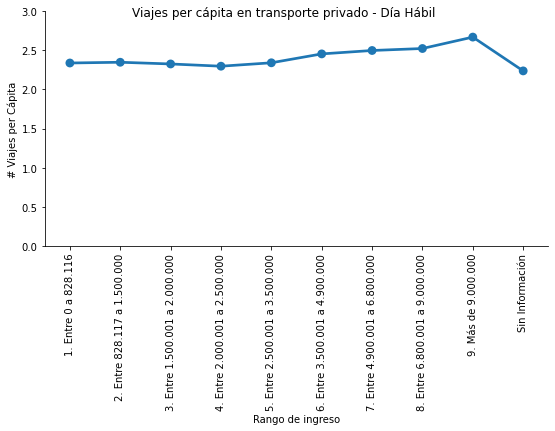

In [ ]:
g = sns.catplot(x="id_rango_ingresos", y="viajes_per_capita", 
                capsize=.2, height=4, aspect=2,
                kind="point", data=df)

g.fig.suptitle('Viajes per cápita en transporte privado - Día Hábil')
g.set_ylabels('# Viajes per Cápita')
g.set_xlabels('Rango de ingreso')
g.set_xticklabels(rotation=90)
g.set(ylim=(0,3))

fig.tight_layout()

In [ ]:
print('Viajes per cápita en transporte privado - Día No Hábil')
df = calculate_n_viajes_per_capita(viajes_privado_nohabiles, "viajes_privado_nohabiles", "id_rango_ingresos", ["id_rango_ingresos"], 'id_persona_u', 'f_exp_y', 'f_exp_x')

Viajes per cápita en transporte privado - Día No Hábil


/usr/local/lib/python3.7/site-packages/pandasql/sqldf.py:121: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  index=not any(name is None for name in df.index.names))  # load index into db if all levels are named


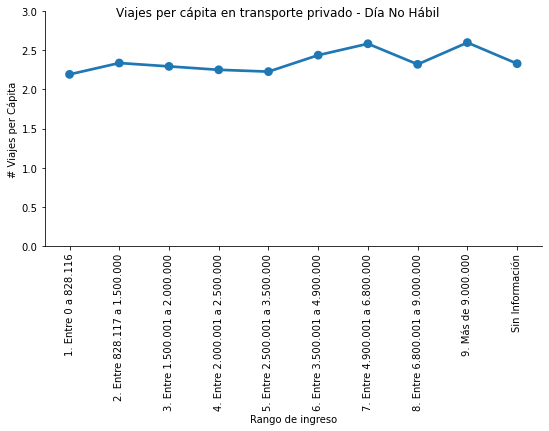

In [ ]:
g = sns.catplot(x="id_rango_ingresos", y="viajes_per_capita", 
                capsize=.2, height=4, aspect=2,
                kind="point", data=df)

g.fig.suptitle('Viajes per cápita en transporte privado - Día No Hábil')
g.set_ylabels('# Viajes per Cápita')
g.set_xlabels('Rango de ingreso')
g.set_xticklabels(rotation=90)
g.set(ylim=(0,3))

fig.tight_layout()

Durante días hábiles y no hábiles, se ve que hay un aumento de viajes per cápita en transporte privado a medida que aumenta el rango de ingreso.

#### **¿Cuál es la razón entre los viajes en transporte público y privado por clasificador socioeconómico?**

Los gráficos a continuación muestran la razón entre los viajes en transporte público y transporte privado durante días hábiles y no hábiles, por clasificador socioeconómico.

In [ ]:
print('Razón entre los viajes en transporte público y privado - Día Hábil')
df = viajes_privado_habiles.groupby(["id_rango_ingresos"]).agg(n_viajes = ('f_exp_x', 'sum')) / viajes_publico_habiles.groupby(['id_rango_ingresos']).agg(n_viajes = ('f_exp_x', 'sum'))
df = df.reset_index()

Razón entre los viajes en transporte público y privado - Día Hábil


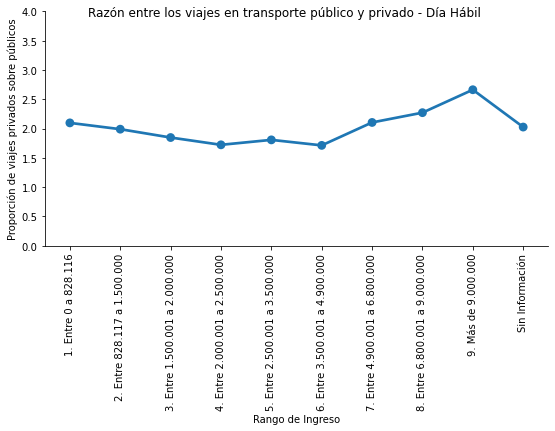

In [ ]:
g = sns.catplot(x="id_rango_ingresos", y="n_viajes",
                capsize=.2, height=4, aspect=2,
                kind="point", data=df)

g.fig.suptitle('Razón entre los viajes en transporte público y privado - Día Hábil')
g.set_ylabels('Proporción de viajes privados sobre públicos')
g.set_xlabels('Rango de Ingreso')
g.set_xticklabels(rotation=90)
g.set(ylim=(0,4))

fig.tight_layout()

In [ ]:
print('Razón entre los viajes en transporte público y privado - Día No Hábil')
df = viajes_privado_nohabiles.groupby(["id_rango_ingresos"]).agg(n_viajes = ('f_exp_x', 'sum')) / viajes_publico_nohabiles.groupby(["id_rango_ingresos"]).agg(n_viajes = ('f_exp_x', 'sum'))
df = df.reset_index()

Razón entre los viajes en transporte público y privado - Día No Hábil


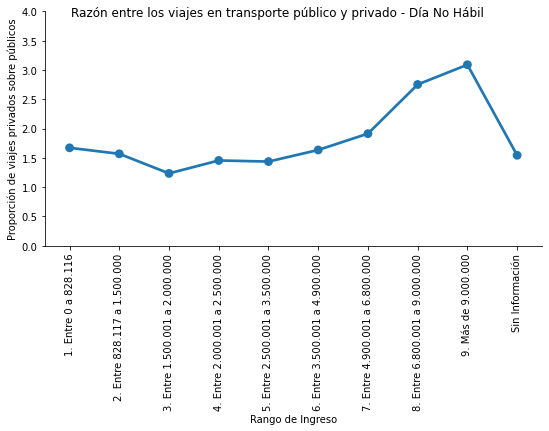

In [ ]:
g = sns.catplot(x="id_rango_ingresos", y="n_viajes",
                capsize=.2, height=4, aspect=2,
                kind="point", data=df)

g.fig.suptitle('Razón entre los viajes en transporte público y privado - Día No Hábil')
g.set_ylabels('Proporción de viajes privados sobre públicos')
g.set_xlabels('Rango de Ingreso')
g.set_xticklabels(rotation=90)
g.set(ylim=(0,4))

fig.tight_layout()

Tanto en días hábiles y no hábiles, la razón entre viajes privados sobre públicos aumenta a medida que aumenta el rango de ingreso.

#### **¿Cuál es la distribución/partición modal de los viajes por clasificador socioeconómico?**

Las siguientes tablas y gráficos representan la partición modal de los viajes realizados en días hábiles y no hábiles, por clasificador socioeconómico.

In [ ]:
print('Partición Modal de los Viajes - Día Hábil')
df = viajes_habiles.groupby(["id_rango_ingresos", 'modo_principal']).sum()['f_exp_x'].unstack()
#.agg(count=('MEDIO_PREDOMINANTE','count')).unstack()
df_norm = df.div(df.sum(axis=1), axis=0)

Partición Modal de los Viajes - Día Hábil


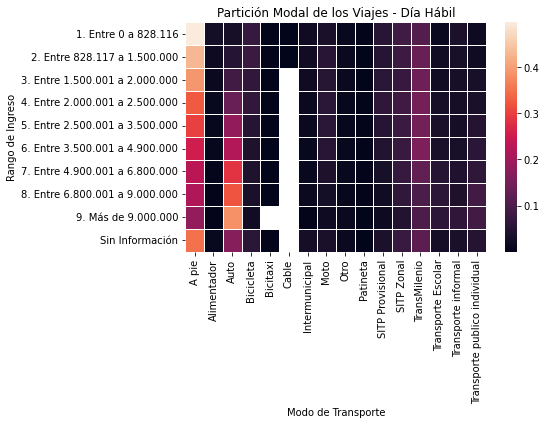

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))

ax = sns.heatmap(df_norm,linewidth=0.5)

ax.set_title("Partición Modal de los Viajes - Día Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Rango de Ingreso")

fig.tight_layout()

In [ ]:
print('Partición Modal de los Viajes - Día No Hábil')
df = viajes_nohabiles.groupby(["id_rango_ingresos", 'modo_principal']).sum()['f_exp_x'].unstack()
#.agg(count=('MEDIO_PREDOMINANTE','count')).unstack()
df_norm = df.div(df.sum(axis=1), axis=0)

Partición Modal de los Viajes - Día No Hábil


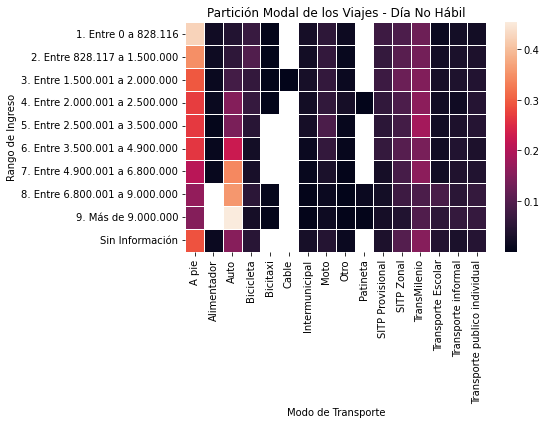

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))

ax = sns.heatmap(df_norm,linewidth=0.5)

ax.set_title("Partición Modal de los Viajes - Día No Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Rango de Ingreso")

fig.tight_layout()

La distribución de modos de transporte muestra que los modos más utilizados son A pie, Auto y Transmilenio. El modo A pie aumenta a medida que disminuye el rango de ingreso, mientras que Auto aumenta con el rango de ingreso.

In [ ]:
print('Partición Modal de los Viajes de acuerdo al tipo de transporte - Día Hábil')
df = viajes_habiles.groupby(["id_rango_ingresos", 'publico_privado']).sum()['f_exp_x'].unstack()
df_norm = df.div(df.sum(axis=1), axis=0)

Partición Modal de los Viajes de acuerdo al tipo de transporte - Día Hábil


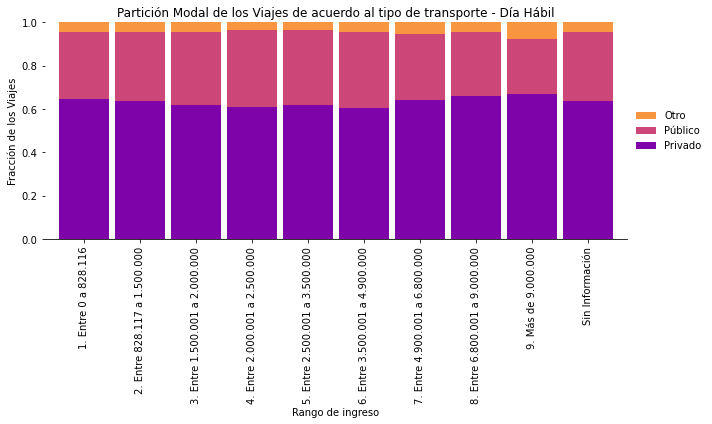

In [ ]:
from aves.visualization.tables import barchart

fig, ax = plt.subplots(figsize=(10,6))

barchart(
    ax, df_norm, stacked=True, normalize=False, sort_categories=True, sort_items=False
)

ax.set_title("Partición Modal de los Viajes de acuerdo al tipo de transporte - Día Hábil")
ax.set_ylim([0, 1])
ax.set_xlabel("Rango de ingreso")
ax.set_ylabel("Fracción de los Viajes")

fig.tight_layout()

In [ ]:
print('Partición Modal de los Viajes de acuerdo al tipo de transporte - Día No Hábil')
df = viajes_nohabiles.groupby(["id_rango_ingresos", 'publico_privado']).sum()['f_exp_x'].unstack()
df_norm = df.div(df.sum(axis=1), axis=0)

Partición Modal de los Viajes de acuerdo al tipo de transporte - Día No Hábil


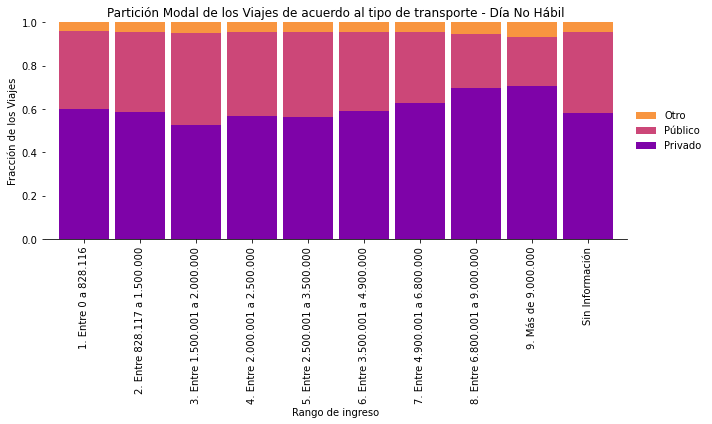

In [ ]:
from aves.visualization.tables import barchart

fig, ax = plt.subplots(figsize=(10, 6))

barchart(
    ax, df_norm, stacked=True, normalize=False, sort_categories=True, sort_items=False
)

ax.set_title("Partición Modal de los Viajes de acuerdo al tipo de transporte - Día No Hábil")
ax.set_ylim([0, 1])
ax.set_xlabel("Rango de ingreso")
ax.set_ylabel("Fracción de los Viajes")

fig.tight_layout()

En días hábiles, la partición por tipo de transporte no muestra diferencias a través de los rangos de ingreso, pero en días no hábiles, la fracción de viajes privados aumenta a medida que aumenta el tramo de ingreso.

### Parte II: Indicadores de Tiempo de Viajes

En esta segunda parte, responderemos algunas preguntas respecto a indicadores de tiempo de viajes realizados, en días hábiles y no hábiles de viaje. Para esto, buscaremos responder las siguientes preguntas:
1. ¿Cuál es el tiempo promedio de viaje por modo y tipo de transporte?
2. ¿Cuál es el tiempo promedio de viaje en hora punta de mañana?
3. ¿Cuál es el tiempo de viaje en transporte público en hora punta de mañana?
4. ¿Cuál es el tiempo promedio de viaje al trabajo en transporte público?

En esta sección, se presentarán los indicadores de tiempo de viajes a nivel de viajes, durante días hábiles, y por clasificador socioeconómico.

In [ ]:
viajes_habiles['duracion_minutos'] = pd.to_timedelta(viajes_habiles['duracion'])/pd.Timedelta('60s')
viajes_nohabiles['duracion_minutos'] = pd.to_timedelta(viajes_nohabiles['duracion'])/pd.Timedelta('60s')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
def weighted_median(df, val, weight):
    df_sorted = df.sort_values(val)
    cumsum = df_sorted[weight].cumsum()
    cutoff = df_sorted[weight].sum() / 2.
    return df_sorted[cumsum >= cutoff][val].iloc[0]

#### **¿Cuál es el tiempo promedio de viaje por modo y tipo de transporte?**

A continuación, se representa el promedio y mediana en minutos de viaje por modo y tipo de transporte en días hábiles y no hábiles, por clasificador socioeconómico.

In [ ]:
print('Duración promedio (en minutos) de viaje por modo - Dia Hábil')
df = viajes_habiles.groupby(["id_rango_ingresos", 'modo_principal']).apply(lambda x: weighted_mean(x, 'duracion_minutos', 'f_exp_x')).unstack()

Duración promedio (en minutos) de viaje por modo - Dia Hábil


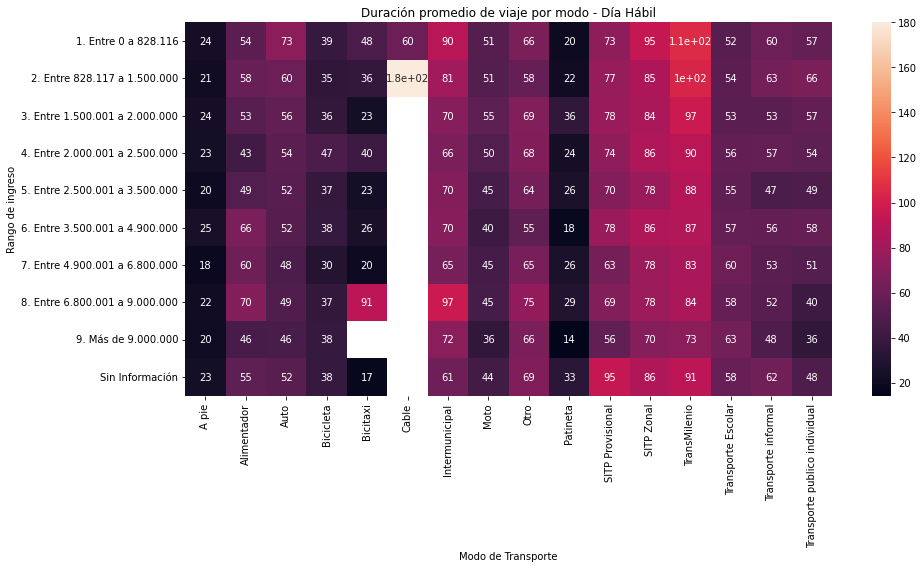

In [ ]:
fig, ax = plt.subplots(figsize=(14, 8))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración promedio de viaje por modo - Día Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Rango de ingreso")

fig.tight_layout()

In [ ]:
print('Duración mediana (en minutos) de viaje por modo - Dia Hábil')
df = viajes_habiles.groupby(["id_rango_ingresos", 'modo_principal']).apply(lambda x: weighted_median(x, 'duracion_minutos', 'f_exp_x')).unstack()

Duración mediana (en minutos) de viaje por modo - Dia Hábil


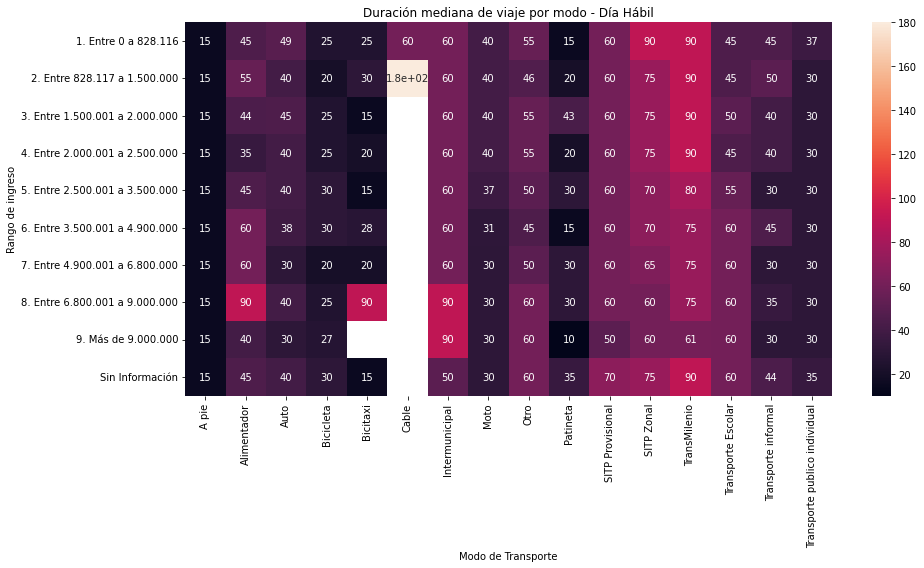

In [ ]:
fig, ax = plt.subplots(figsize=(14, 8))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración mediana de viaje por modo - Día Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Rango de ingreso")

fig.tight_layout()

In [ ]:
print('Duración promedio (en minutos) de viaje por modo - Dia No Hábil')
df = viajes_nohabiles.groupby(["id_rango_ingresos", 'modo_principal']).apply(lambda x: weighted_mean(x, 'duracion_minutos', 'f_exp_x')).unstack()

Duración promedio (en minutos) de viaje por modo - Dia No Hábil


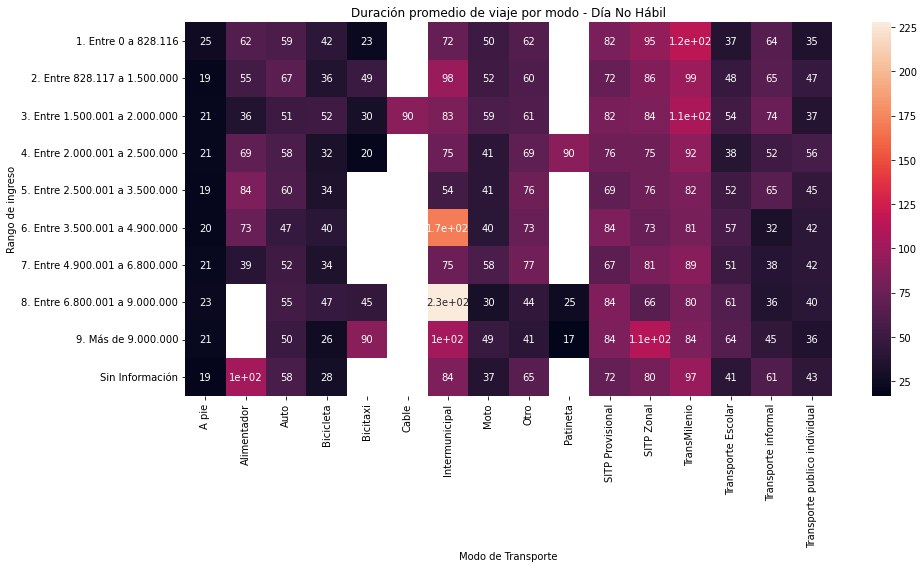

In [ ]:
fig, ax = plt.subplots(figsize=(14, 8))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración promedio de viaje por modo - Día No Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Rango de ingreso")

fig.tight_layout()

In [ ]:
print('Duración mediana (en minutos) de viaje por modo - Dia No Hábil')
df = viajes_nohabiles.groupby(["id_rango_ingresos", 'modo_principal']).apply(lambda x: weighted_median(x, 'duracion_minutos', 'f_exp_x')).unstack()

Duración mediana (en minutos) de viaje por modo - Dia No Hábil


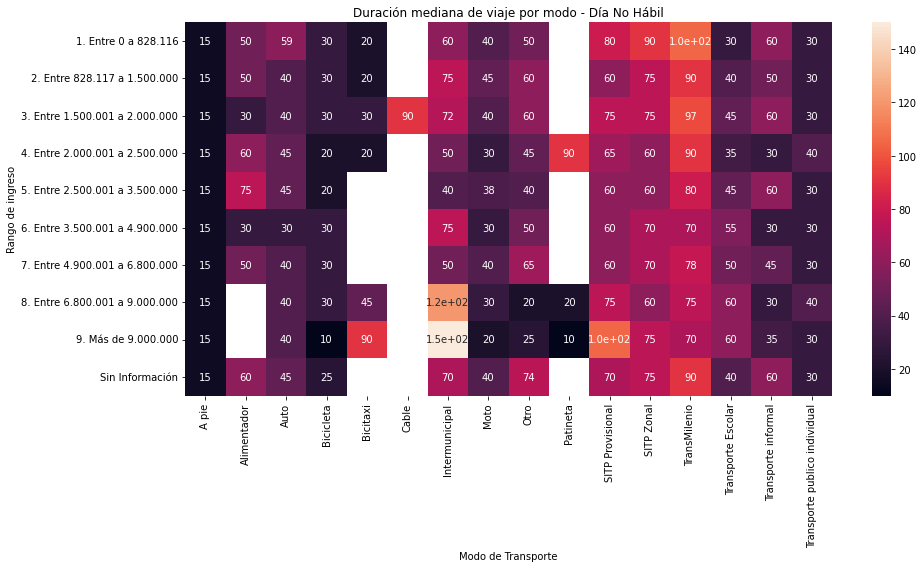

In [ ]:
fig, ax = plt.subplots(figsize=(14, 8))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración mediana de viaje por modo - Día No Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Rango de ingreso")

fig.tight_layout()

En días hábiles, los modos de transporte con viajes de mayor duración corresponden a los realizados en SITP Provisional, SIPT Zonal y Transmilenio, mientras que los viajes más cortos son los realizados a pie. En días no hábiles, los viajes más largos son los realizados en modo Intermunicipal.

In [ ]:
print('Duración promedio (en minutos) de viaje por tipo de transporte - Dia Hábil')
df = viajes_habiles.groupby(["id_rango_ingresos", 'publico_privado']).apply(lambda x: weighted_mean(x, 'duracion_minutos', 'f_exp_x')).unstack()

Duración promedio (en minutos) de viaje por tipo de transporte - Dia Hábil


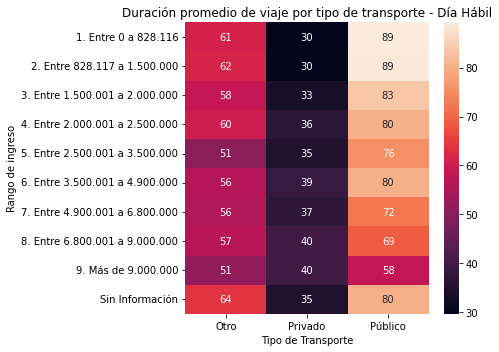

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración promedio de viaje por tipo de transporte - Día Hábil")
ax.set_xlabel("Tipo de Transporte")
ax.set_ylabel("Rango de ingreso")

fig.tight_layout()

In [ ]:
print('Duración mediana (en minutos) de viaje por tipo de transporte - Dia Hábil')
df = viajes_habiles.groupby(["id_rango_ingresos", 'publico_privado']).apply(lambda x: weighted_median(x, 'duracion_minutos', 'f_exp_x')).unstack()

Duración mediana (en minutos) de viaje por tipo de transporte - Dia Hábil


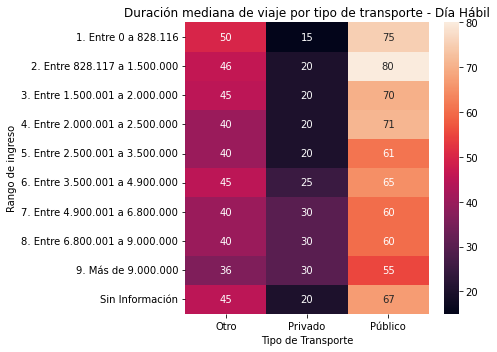

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración mediana de viaje por tipo de transporte - Día Hábil")
ax.set_xlabel("Tipo de Transporte")
ax.set_ylabel("Rango de ingreso")

fig.tight_layout()

In [ ]:
print('Duración promedio (en minutos) de viaje por tipo de transporte - Dia Hábil')
df = viajes_habiles.groupby(["id_rango_ingresos", 'motorizado']).apply(lambda x: weighted_mean(x, 'duracion_minutos', 'f_exp_x')).unstack()

Duración promedio (en minutos) de viaje por tipo de transporte - Dia Hábil


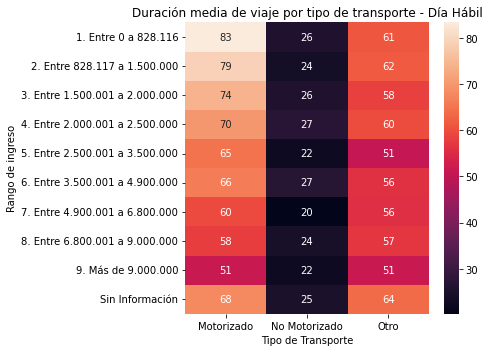

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración media de viaje por tipo de transporte - Día Hábil")
ax.set_xlabel("Tipo de Transporte")
ax.set_ylabel("Rango de ingreso")

fig.tight_layout()

In [ ]:
print('Duración promedio (en minutos) de viaje por tipo de transporte - Dia Hábil')
df = viajes_habiles.groupby(["id_rango_ingresos", 'motorizado']).apply(lambda x: weighted_median(x, 'duracion_minutos', 'f_exp_x')).unstack()

Duración promedio (en minutos) de viaje por tipo de transporte - Dia Hábil


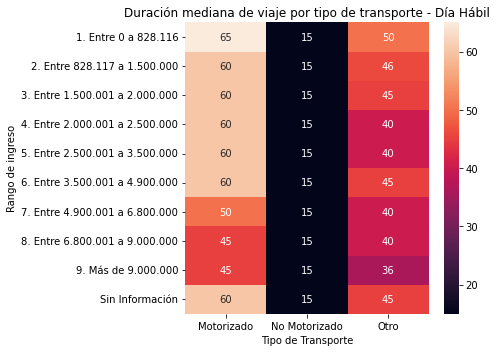

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración mediana de viaje por tipo de transporte - Día Hábil")
ax.set_xlabel("Tipo de Transporte")
ax.set_ylabel("Rango de ingreso")

fig.tight_layout()

El transporte público tiene mayores duraciones de viaje que el viaje privado, y no tiene diferencia a través de los tramos, solo en el tramo más bajo de ingreso, donde la duración de los viajes es mayor en el transporte público.

#### **¿Cuál es el tiempo promedio de viaje en hora punta de mañana?**

Estos son los resultados para el promedio y mediana en minutos de viaje en hora punta de la mañana por modo de transporte, en días hábiles y no hábiles, por clasificador socioeconómico.

In [ ]:
print('Duración promedio (en minutos) de viaje por modo en hora punta - Dia Hábil')
df = viajes_habiles[viajes_habiles.PICO_HABIL=='Si'].groupby(['id_rango_ingresos', 'modo_principal']).apply(lambda x: weighted_mean(x, 'duracion_minutos', 'f_exp_x')).unstack()

Duración promedio (en minutos) de viaje por modo en hora punta - Dia Hábil


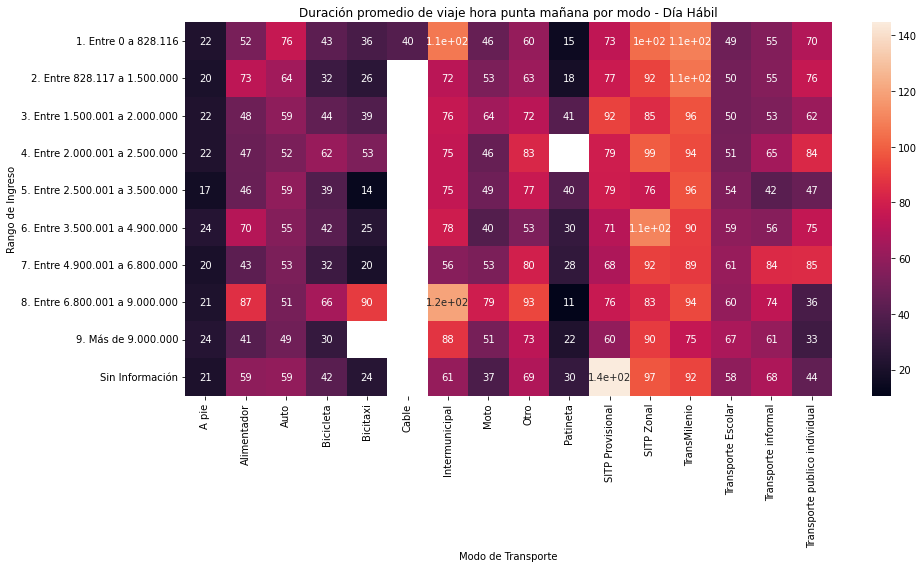

In [ ]:
fig, ax = plt.subplots(figsize=(14, 8))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración promedio de viaje hora punta mañana por modo - Día Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Rango de Ingreso")

fig.tight_layout()

In [ ]:
print('Duración mediana (en minutos) de viaje por modo en hora punta - Dia Hábil')
df = viajes_habiles[viajes_habiles.PICO_HABIL=='Si'].groupby(['id_rango_ingresos', 'modo_principal']).apply(lambda x: weighted_median(x, 'duracion_minutos', 'f_exp_x')).unstack()

Duración mediana (en minutos) de viaje por modo en hora punta - Dia Hábil


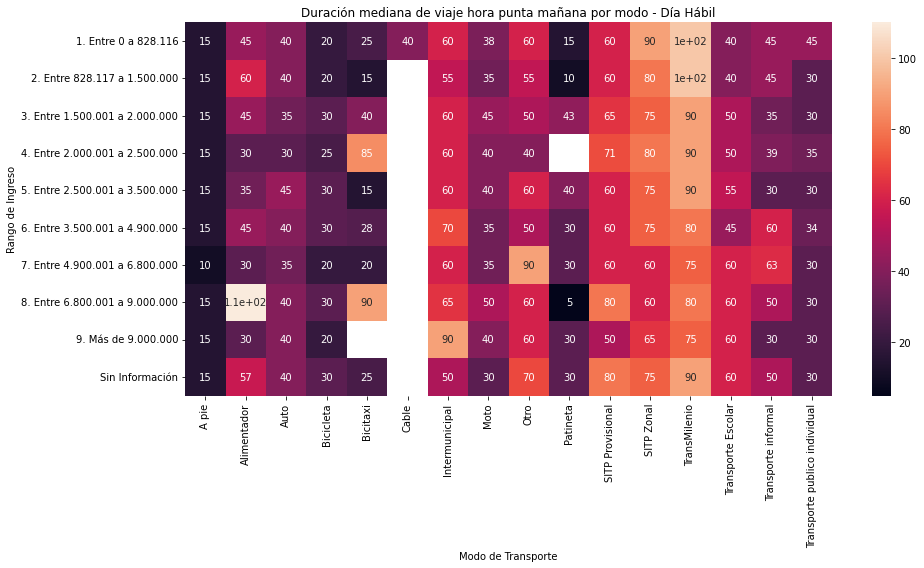

In [ ]:
fig, ax = plt.subplots(figsize=(14, 8))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración mediana de viaje hora punta mañana por modo - Día Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Rango de Ingreso")

fig.tight_layout()

In [ ]:
print('Duración promedio (en minutos) de viaje por modo en hora punta - Dia No Hábil')
df = viajes_nohabiles[viajes_nohabiles.PICO_NOHABIL=='Si'].groupby(['id_rango_ingresos', 'modo_principal']).apply(lambda x: weighted_mean(x, 'duracion_minutos', 'f_exp_x')).unstack()

Duración promedio (en minutos) de viaje por modo en hora punta - Dia No Hábil


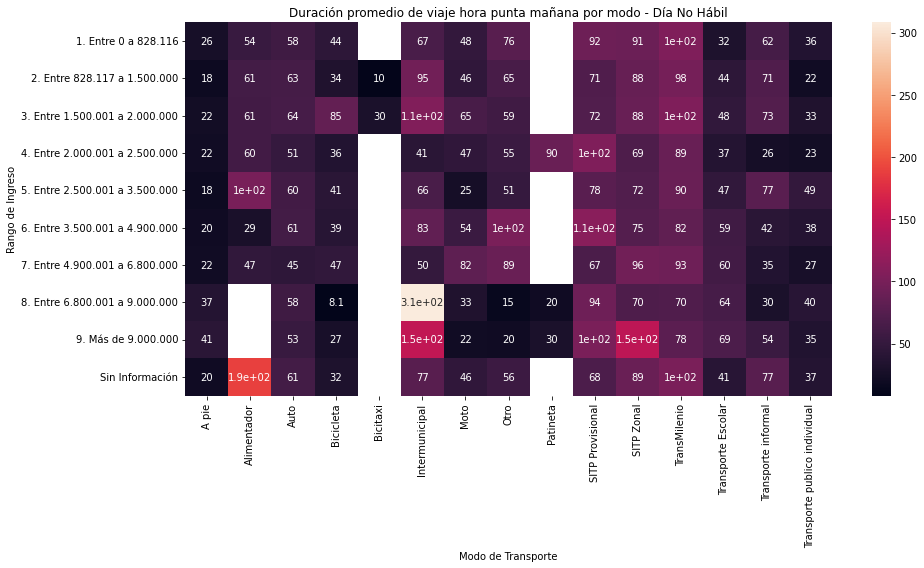

In [ ]:
fig, ax = plt.subplots(figsize=(14, 8))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración promedio de viaje hora punta mañana por modo - Día No Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Rango de Ingreso")

fig.tight_layout()

In [ ]:
print('Duración mediana (en minutos) de viaje por modo en hora punta - Dia No Hábil')
df = viajes_nohabiles[viajes_nohabiles.PICO_NOHABIL=='Si'].groupby(['id_rango_ingresos', 'modo_principal']).apply(lambda x: weighted_median(x, 'duracion_minutos', 'f_exp_x')).unstack()

Duración mediana (en minutos) de viaje por modo en hora punta - Dia No Hábil


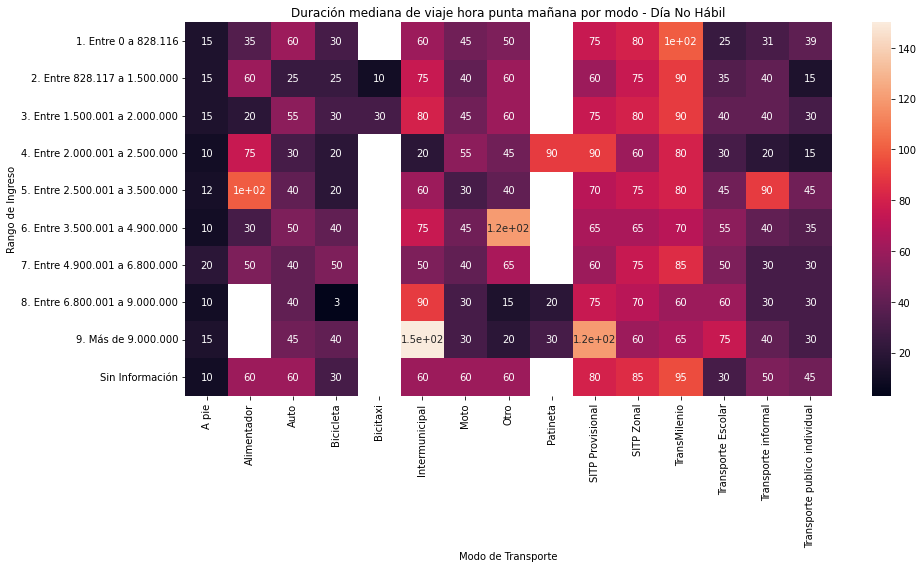

In [ ]:
fig, ax = plt.subplots(figsize=(14, 8))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración mediana de viaje hora punta mañana por modo - Día No Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Rango de Ingreso")

fig.tight_layout()

Independiente del día, los viajes con mayores tiempos promedio de viaje en hora punta de mañana corresponden a los realizados en los modos Intermunicipal, SITP Provisional, SITP Zonal y TransMilenio, y los viajes más cortos corresponden a los hechos A Pie.

In [ ]:
print('Duración promedio (en minutos) de viaje por tipo de transporte en hora punta - Dia Hábil')
df = viajes_habiles[(viajes_habiles.PICO_HABIL=='Si')].groupby(['id_rango_ingresos','publico_privado']).apply(lambda x: weighted_mean(x, 'duracion_minutos', 'f_exp_x')).unstack()

Duración promedio (en minutos) de viaje por tipo de transporte en hora punta - Dia Hábil


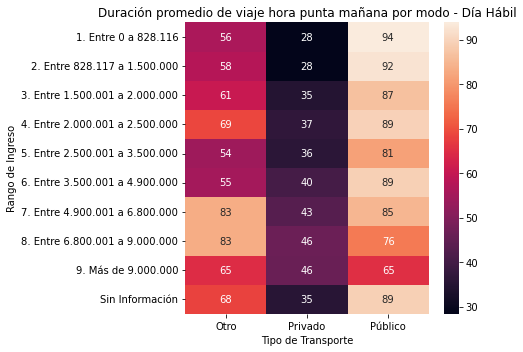

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración promedio de viaje hora punta mañana por modo - Día Hábil")
ax.set_xlabel("Tipo de Transporte")
ax.set_ylabel("Rango de Ingreso")

fig.tight_layout()

In [ ]:
print('Duración mediana (en minutos) de viaje por tipo de transporte en hora punta - Dia Hábil')
df = viajes_habiles[(viajes_habiles.PICO_HABIL=='Si')].groupby(['id_rango_ingresos','publico_privado']).apply(lambda x: weighted_median(x, 'duracion_minutos', 'f_exp_x')).unstack()

Duración mediana (en minutos) de viaje por tipo de transporte en hora punta - Dia Hábil


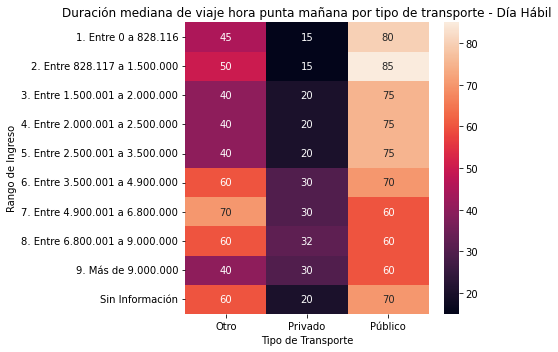

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración mediana de viaje hora punta mañana por tipo de transporte - Día Hábil")
ax.set_xlabel("Tipo de Transporte")
ax.set_ylabel("Rango de Ingreso")

fig.tight_layout()

In [ ]:
print('Duración promedio (en minutos) de viaje por tipo de transporte en hora punta - Dia Hábil')
df = viajes_habiles[(viajes_habiles.PICO_HABIL=='Si')].groupby(['id_rango_ingresos','motorizado']).apply(lambda x: weighted_mean(x, 'duracion_minutos', 'f_exp_x')).unstack()

Duración promedio (en minutos) de viaje por tipo de transporte en hora punta - Dia Hábil


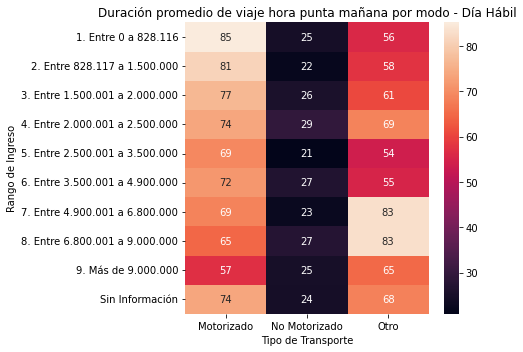

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración promedio de viaje hora punta mañana por modo - Día Hábil")
ax.set_xlabel("Tipo de Transporte")
ax.set_ylabel("Rango de Ingreso")

fig.tight_layout()

In [ ]:
print('Duración mediana (en minutos) de viaje por tipo de transporte en hora punta - Dia Hábil')
df = viajes_habiles[(viajes_habiles.PICO_HABIL=='Si')].groupby(['id_rango_ingresos','motorizado']).apply(lambda x: weighted_median(x, 'duracion_minutos', 'f_exp_x')).unstack()

Duración mediana (en minutos) de viaje por tipo de transporte en hora punta - Dia Hábil


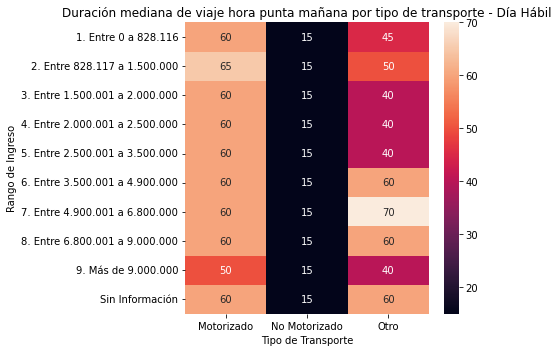

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración mediana de viaje hora punta mañana por tipo de transporte - Día Hábil")
ax.set_xlabel("Tipo de Transporte")
ax.set_ylabel("Rango de Ingreso")

fig.tight_layout()

Para ambos días, la duración de los viajes realizados en hora punta de mañana es mayor en el transporte público que en el transporte privado, con duraciones similares a lo largo de los rangos de ingreso.

#### **¿Cuál es el tiempo de viaje en transporte público en hora punta de mañana?**

A continuación, se presentan los resultados para duración promedio de viaje en hora punta de mañana en transporte público, en días hábiles y no hábiles, por clasificador socioeconómico.

In [ ]:
print('Duración promedio (en minutos) de viaje hora punta en transporte público - Dia Hábil')
mask = (viajes_habiles.publico_privado=='Público')
df = viajes_habiles[(viajes_habiles.PICO_HABIL=='Si')][mask].groupby(['id_rango_ingresos', 'modo_principal']).apply(lambda x: weighted_mean(x, 'duracion_minutos', 'f_exp_x')).unstack()

Duración promedio (en minutos) de viaje hora punta en transporte público - Dia Hábil


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


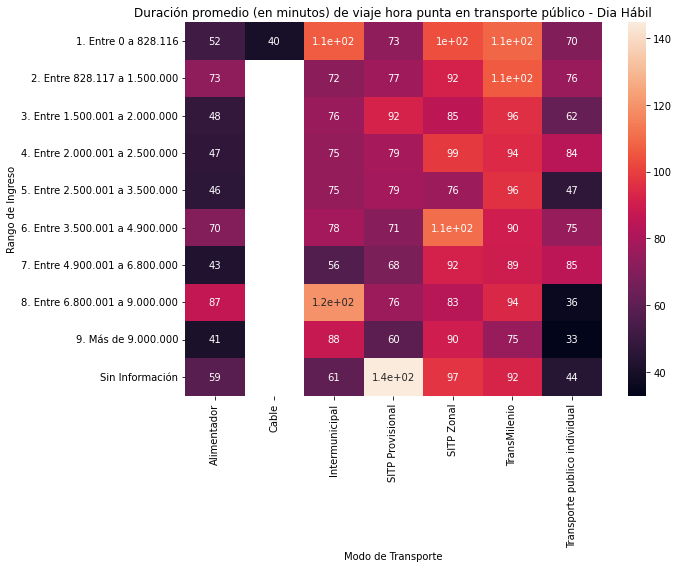

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración promedio (en minutos) de viaje hora punta en transporte público - Dia Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Rango de Ingreso")

fig.tight_layout()

In [ ]:
print('Duración mediana (en minutos) de viaje al trabajo en transporte público - Dia Hábil')
mask = (viajes_habiles.publico_privado=='Público')
df = viajes_habiles[(viajes_habiles.PICO_HABIL=='Si')][mask].groupby(['id_rango_ingresos','modo_principal']).apply(lambda x: weighted_median(x, 'duracion_minutos', 'f_exp_x')).unstack()

Duración mediana (en minutos) de viaje al trabajo en transporte público - Dia Hábil


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


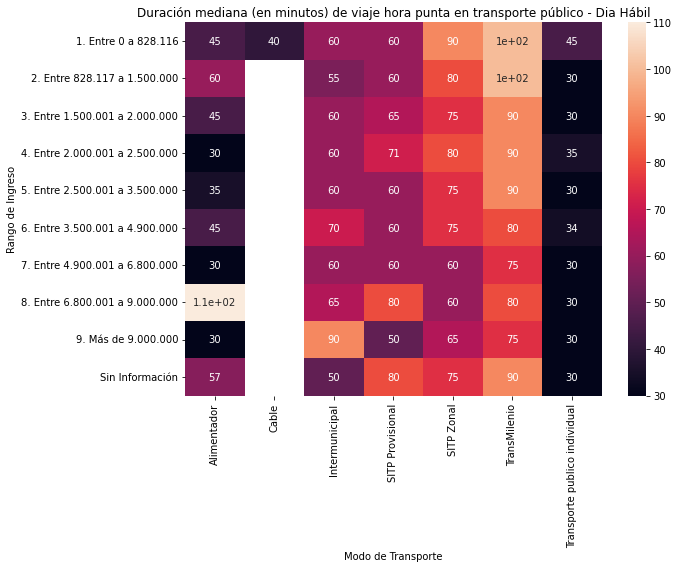

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración mediana (en minutos) de viaje hora punta en transporte público - Dia Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Rango de Ingreso")

fig.tight_layout()

En días hábiles, el modo de transporte público con mayor duración de viajes es el Intermunicipal, mientras que el Transporte público individual presenta las menores duraciones de viaje.

#### **¿Cuál es el tiempo promedio de viaje al trabajo en transporte público?**

A continuación, se presentan los resultados de tiempo promedio de viaje al trabajo en transporte público por modo en días hábiles y no hábiles, por clasificador socioeconómico.

In [ ]:
print('Duración promedio (en minutos) de viaje al trabajo en transporte público - Dia Hábil')
mask = (viajes_habiles.publico_privado=='Público') & (viajes_habiles.p17_Id_motivo_viaje=='Trabajar')
df = viajes_habiles[mask].groupby(['id_rango_ingresos', 'modo_principal']).apply(lambda x: weighted_mean(x, 'duracion_minutos', 'f_exp_x')).unstack()

Duración promedio (en minutos) de viaje al trabajo en transporte público - Dia Hábil


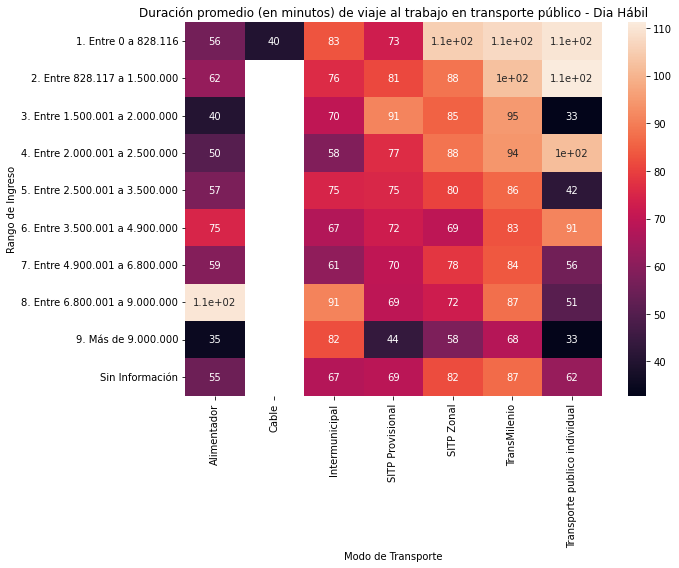

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración promedio (en minutos) de viaje al trabajo en transporte público - Dia Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Rango de Ingreso")

fig.tight_layout()

In [ ]:
print('Duración mediana (en minutos) de viaje al trabajo en transporte público - Dia Hábil')
mask = (viajes_habiles.publico_privado=='Público') & (viajes_habiles.p17_Id_motivo_viaje=='Trabajar')
df = viajes_habiles[mask].groupby(['id_rango_ingresos', 'modo_principal']).apply(lambda x: weighted_median(x, 'duracion_minutos', 'f_exp_x')).unstack()

Duración mediana (en minutos) de viaje al trabajo en transporte público - Dia Hábil


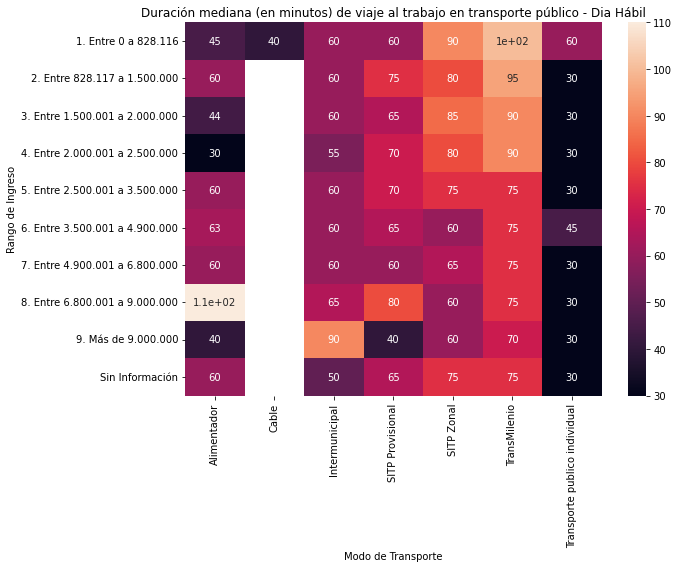

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración mediana (en minutos) de viaje al trabajo en transporte público - Dia Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Rango de Ingreso")

fig.tight_layout()

En días hábiles, los viajes al trabajo en transporte público con mayor duración corresponden al Transmilenio transversalmente.

### Parte III: Indicadores de Distancia de Viajes


En esta sección, se presentarán los indicadores de distancia de viajes durante días hábiles.

#### **Distancia de viajes en auto (histograma de viajes por km)**

In [ ]:
from matplotlib.pyplot import hist

Distancia de viajes en auto - Día Hábil


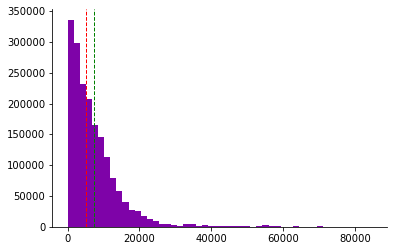

In [ ]:
print('Distancia de viajes en auto - Día Hábil')
mask = (viajes_habiles.modo_principal == 'Auto') 
df = viajes_habiles[mask].groupby('distancia_manhattan').sum()[['f_exp_x']].reset_index().sort_values('distancia_manhattan')
hist(df.distancia_manhattan, weights=df.f_exp_x, bins=50)
plt.axvline(viajes_habiles[mask].groupby('id_viaje_u').apply(lambda x: weighted_mean(x, 'distancia_manhattan', 'f_exp_x')).mean(), color='green', linestyle='dashed', linewidth=1)
plt.axvline(viajes_habiles[mask].groupby('id_viaje_u').apply(lambda x: weighted_median(x, 'distancia_manhattan', 'f_exp_x')).median(), color='red', linestyle='dashed', linewidth=1)
sns.despine()
#Verde Promedio
#Rojo Mediana

Distancia de viajes en auto - Día No Hábil


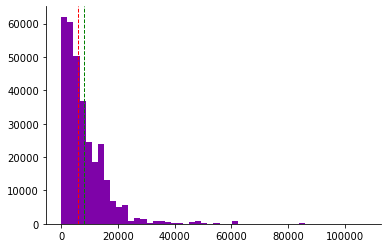

In [ ]:
print('Distancia de viajes en auto - Día No Hábil')
mask = (viajes_nohabiles.modo_principal == 'Auto')
df = viajes_nohabiles[mask].groupby('distancia_manhattan').sum()[['f_exp_x']].reset_index().sort_values('distancia_manhattan')
hist(df.distancia_manhattan, weights=df.f_exp_x, bins=50)
plt.axvline(viajes_nohabiles[mask].groupby('id_viaje_u').apply(lambda x: weighted_mean(x, 'distancia_manhattan', 'f_exp_x')).mean(), color='green', linestyle='dashed', linewidth=1)
plt.axvline(viajes_nohabiles[mask].groupby('id_viaje_u').apply(lambda x: weighted_median(x, 'distancia_manhattan', 'f_exp_x')).median(), color='red', linestyle='dashed', linewidth=1)
sns.despine()
#Verde Promedio
#Rojo Mediana

#### **Distancia de viajes en transporte público**

Distancia de viajes en transporte público - Día Hábil


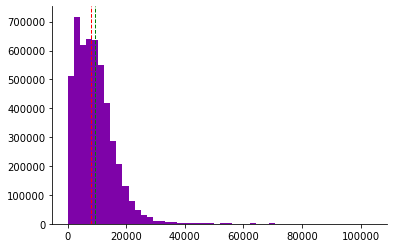

In [ ]:
print('Distancia de viajes en transporte público - Día Hábil')
mask = (viajes_habiles.publico_privado == 'Público')
df = viajes_habiles[mask].groupby('distancia_manhattan').sum()[['f_exp_x']].reset_index().sort_values('distancia_manhattan')
hist(df.distancia_manhattan, weights=df.f_exp_x, bins=50)
plt.axvline(viajes_habiles[mask].groupby('id_viaje_u').apply(lambda x: weighted_mean(x, 'distancia_manhattan', 'f_exp_x')).mean(), color='green', linestyle='dashed', linewidth=1)
plt.axvline(viajes_habiles[mask].groupby('id_viaje_u').apply(lambda x: weighted_median(x, 'distancia_manhattan', 'f_exp_x')).median(), color='red', linestyle='dashed', linewidth=1)
sns.despine()
#Verde Promedio
#Rojo Mediana

Distancia de viajes en transporte público - Día No Hábil


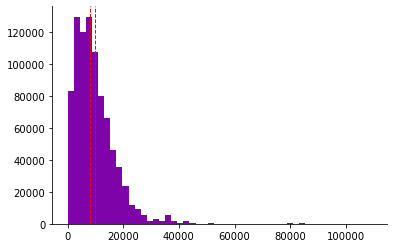

In [ ]:
print('Distancia de viajes en transporte público - Día No Hábil')
mask = (viajes_nohabiles.publico_privado == 'Público')
df = viajes_nohabiles[mask].groupby('distancia_manhattan').sum()[['f_exp_x']].reset_index().sort_values('distancia_manhattan')
hist(df.distancia_manhattan, weights=df.f_exp_x, bins=50)
plt.axvline(viajes_nohabiles[mask].groupby('id_viaje_u').apply(lambda x: weighted_mean(x, 'distancia_manhattan', 'f_exp_x')).mean(), color='green', linestyle='dashed', linewidth=1)
plt.axvline(viajes_nohabiles[mask].groupby('id_viaje_u').apply(lambda x: weighted_median(x, 'distancia_manhattan', 'f_exp_x')).median(), color='red', linestyle='dashed', linewidth=1)
sns.despine()
#Verde Promedio
#Rojo Mediana

#### **Distancia de viajes por motivo estudio**

Distancia de viajes con motivo de estudio


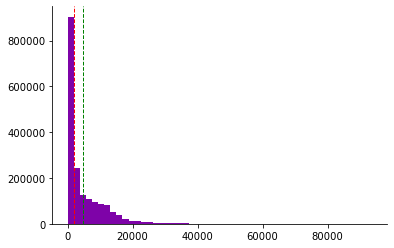

In [ ]:
print('Distancia de viajes con motivo de estudio')
mask = (viajes_personas.p17_Id_motivo_viaje == 'Estudiar')
df = viajes_personas[mask].groupby('distancia_manhattan').sum()[['f_exp_x']].reset_index().sort_values('distancia_manhattan')
hist(df.distancia_manhattan, weights=df.f_exp_x, bins=50)
plt.axvline(viajes_personas[mask].groupby('id_viaje_u').apply(lambda x: weighted_mean(x, 'distancia_manhattan', 'f_exp_x')).mean(), color='green', linestyle='dashed', linewidth=1)
plt.axvline(viajes_personas[mask].groupby('id_viaje_u').apply(lambda x: weighted_median(x, 'distancia_manhattan', 'f_exp_x')).median(), color='red', linestyle='dashed', linewidth=1)
sns.despine()
#Verde Promedio
#Rojo Mediana

#### **Distancia de viajes por motivo trabajo**

Distancia de viajes con motivo de trabajo


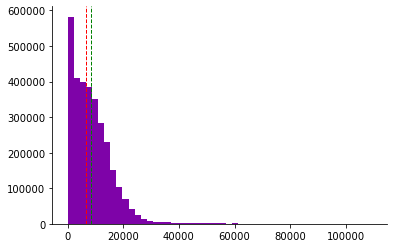

In [ ]:
print('Distancia de viajes con motivo de trabajo')
mask = (viajes_personas.p17_Id_motivo_viaje == 'Trabajar')
df = viajes_personas[mask].groupby('distancia_manhattan').sum()[['f_exp_x']].reset_index().sort_values('distancia_manhattan')
hist(df.distancia_manhattan, weights=df.f_exp_x, bins=50)
plt.axvline(viajes_personas[mask].groupby('id_viaje_u').apply(lambda x: weighted_mean(x, 'distancia_manhattan', 'f_exp_x')).mean(), color='green', linestyle='dashed', linewidth=1)
plt.axvline(viajes_personas[mask].groupby('id_viaje_u').apply(lambda x: weighted_median(x, 'distancia_manhattan', 'f_exp_x')).median(), color='red', linestyle='dashed', linewidth=1)
sns.despine()
#Verde Promedio
#Rojo Mediana

#### **Viajes intra vs interzonales**

In [ ]:
print('% de viajes Inter e Intra zonales')
df = viajes_personas.groupby(['p17_Id_motivo_viaje','Intra_Inter']).sum()['f_exp_x'].unstack()
df.div(df.sum(axis=1), axis=0)

% de viajes Inter e Intra zonales


Intra_Inter,Inter,Intra
p17_Id_motivo_viaje,,
Actividades físicas y deporte,0.806654,0.193346
Actividades religiosas,0.840211,0.159789
Buscar trabajo,0.943436,0.056564
Buscar/Dejar a algo,0.880697,0.119303
Buscar/Dejar a alguien,0.828615,0.171385
Comer/Tomar algo,0.826317,0.173683
Compras,0.787058,0.212942
Cuidado de personas,0.881237,0.118763
Estudiar,0.840304,0.159696


¿Dónde se concentran las personas que utilizan cada modo de transporte en la ciudad para distintos propósitos?

In [ ]:
viajes_personas['ID_ENCUESTA'] = viajes_personas['id_hogar'].astype('str') + viajes_personas['id_persona'].astype('str') + viajes_personas['id_viaje'].astype('str')
viajes_personas.head(1)

,id_hogar,id_persona,id_viaje,zat_origen,p17_Id_motivo_viaje,p17_otro_motivo,hora_inicio_viaje,zat_destino,p31_hora_llegada,fecha,f_exp_x,mun_origen,mun_destino,utam_origen,utam_destino,modo_principal,modo_principal_desagregado,id_viaje_u,LATITUD_ORIGEN,LONGITUD_ORIGEN,LATITUD_DESTINO,LONGITUD_DESTINO,day_of_week,DIA_HABIL,DIA_NOHABIL,Intra_Inter,publico_privado,motorizado,duracion,hora_inicio_viaje_aux,PICO_HABIL,PICO_NOHABIL,distancia_manhattan,Sexo,f_exp_y,p4_edad,p6_id_ocupacion,Id_Hogar,id_rango_ingresos,p5_estrato,p7_Barrio_vivienda,id_persona_u,ID_ENCUESTA
0,33754,2,1,204.0,Ver a alguien,NaN,0 days 08:00:00,554.0,0 days 08:30:00,2019-07-22,54.28656,11001.0,11001.0,UTAM31,UTAM86,SITP Provisional,SITP - Provisional,3375421,4.68374,-74.109,4.63706,-74.1944,Monday,Si,No,Inter,Público,Motorizado,0 days 00:30:00,8.0,No,No,10798.478828,Mujer,54.28656,37,Otra actividad,33754,2. Entre 828.117 a 1.500.000,3,LA ISABELLA,337542,3375421


In [ ]:
from aves.features.geo import clip_area_geodataframe
bbox = [-74.4189,4.3612,-73.8201,5.0477]

zonas_en_caja = clip_area_geodataframe(city_shp.to_crs('epsg:4686'), bbox)
#zonas_en_caja.plot()

/usr/local/lib/python3.7/site-packages/aves/features/geo.py:27: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ).pipe(lambda x: x[x.geometry.area > 0])


In [ ]:
bounds = zonas_en_caja.to_crs('EPSG:4686').total_bounds

In [ ]:
import contextily as cx

scl_img, scl_ext = cx.bounds2raster(bounds[0], bounds[1], bounds[2], bounds[3], 
    "bogota_toner_12.tif",
    ll=True,
    source=cx.providers.Stamen.TonerBackground,
    zoom=12,
)

In [ ]:
from aves.features.geo import to_point_geodataframe

In [ ]:
origenes_viajes = to_point_geodataframe(viajes_personas, 'LONGITUD_ORIGEN' , 'LATITUD_ORIGEN', crs='epsg:4686')
destinos_viajes = to_point_geodataframe(viajes_personas, 'LONGITUD_DESTINO', 'LATITUD_DESTINO', crs='epsg:4686')

In [ ]:
city_shp = city_shp.to_crs(origenes_viajes.crs)

In [ ]:
from aves.features.geo import clip_point_geodataframe

origenes_viajes = origenes_viajes[(origenes_viajes['ID_ENCUESTA'].isin(destinos_viajes['ID_ENCUESTA']))]
origenes_viajes = clip_point_geodataframe(origenes_viajes, zonas_en_caja.total_bounds)
destinos_viajes = destinos_viajes[(destinos_viajes['ID_ENCUESTA'].isin(origenes_viajes['ID_ENCUESTA']))]
destinos_viajes = clip_point_geodataframe(destinos_viajes, zonas_en_caja.total_bounds)

In [ ]:
origenes_viajes.zat_origen.unique()

array([ 204.,  554.,  299., ..., 1019.,  959., 1800.])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


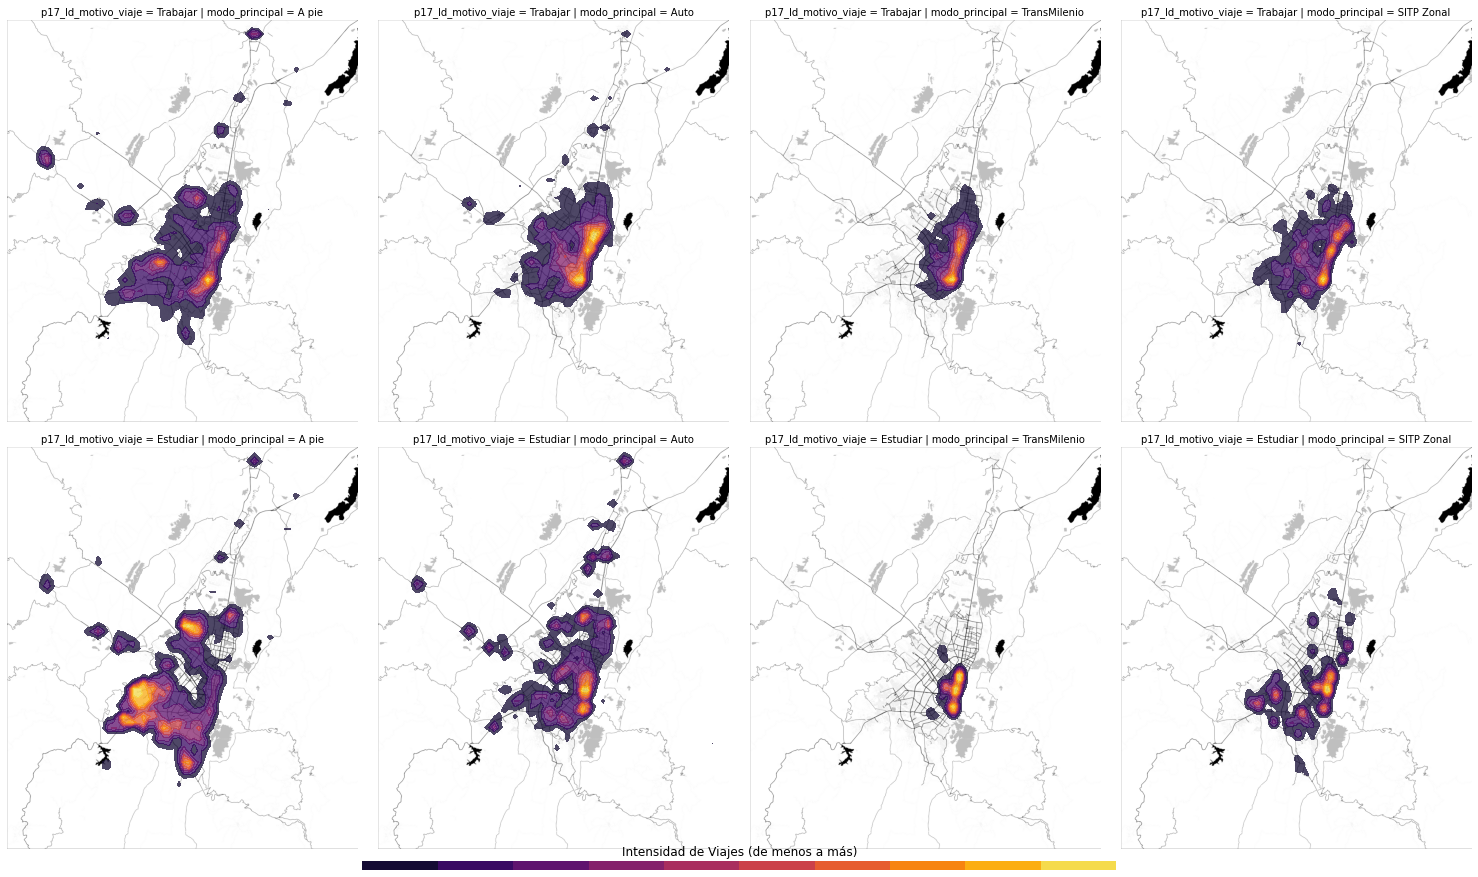

In [ ]:
from aves.visualization.figures import GeoFacetGrid

from aves.visualization.maps import heat_map

grid = GeoFacetGrid(
    origenes_viajes,
    context=zonas_en_caja,
    row="p17_Id_motivo_viaje",
    col="modo_principal",
    row_order=["Trabajar", "Estudiar"],
    col_order=["A pie", "Auto", "TransMilenio", 'SITP Zonal'],
    height=6,
    hue="modo_principal"
)
grid.add_basemap("bogota_toner_12.tif")
#grid.add_layer(city_shp_filt, color="#efefef", edgecolor="white", linewidth=1)

grid.add_layer(
    heat_map,
    # atributo de los datos con la importancia o peso de cada viaje
    weight="f_exp_x",
    # cantidad de niveles/colores del mapa de calor
    n_levels=10,
    # radio de influencia de cada viaje
    bandwidth=0.005,
    # valor de corte para los valores bajos del heatmap
    low_threshold=0.075,
    # transparencia
    alpha=0.75,
    # paleta de colores
    palette="inferno"
)

grid.add_global_colorbar('inferno', 10, title='Intensidad de Viajes (de menos a más)', orientation='horizontal')
#grid.set_title("Viajes a trabajar y a estudiar de acuerdo al modo de transporte")
grid.fig.tight_layout()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


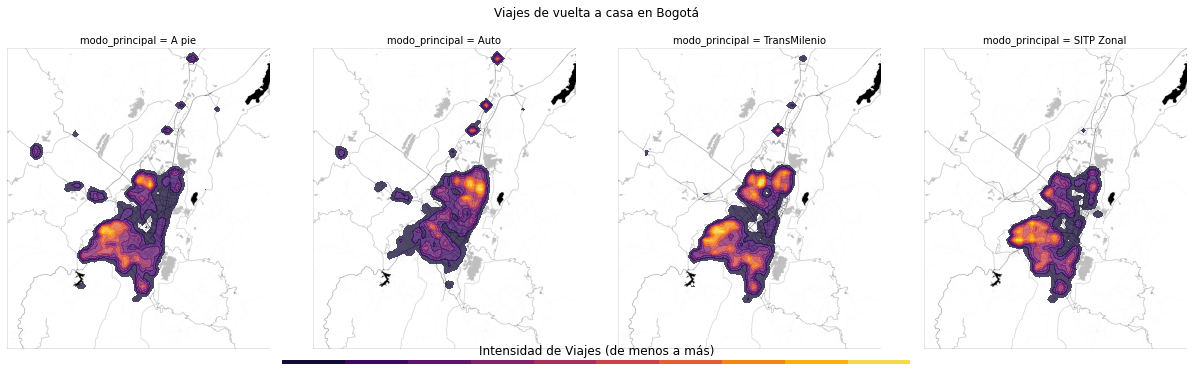

In [ ]:
grid = GeoFacetGrid(
    destinos_viajes[destinos_viajes.p17_Id_motivo_viaje=='Volver a casa'],
    context=zonas_en_caja,
    col="modo_principal",
    #col_wrap=3,
    row_order=["Volver a casa"],
    col_order=["A pie", "Auto", "TransMilenio", 'SITP Zonal'],
    height=5,
    hue="modo_principal"
)
grid.add_basemap("bogota_toner_12.tif")
#grid.add_layer(city_shp_filt, color="#efefef", edgecolor="white", linewidth=1, alpha=0.5)

grid.add_layer(
    heat_map,
    # atributo de los datos con la importancia o peso de cada viaje
    weight="f_exp_x",
    # cantidad de niveles/colores del mapa de calor
    n_levels=10,
    # radio de influencia de cada viaje
    bandwidth=0.005,
    # valor de corte para los valores bajos del heatmap
    low_threshold=0.075,
    # transparencia
    alpha=0.75,
    # paleta de colores
    palette="inferno"
)
grid.add_global_colorbar('inferno', 10, title='Intensidad de Viajes (de menos a más)', orientation='horizontal')
grid.set_title("Viajes de vuelta a casa en Bogotá")
grid.fig.tight_layout()

¿Cuán lejos queda el trabajo de acuerdo al lugar de residencia?

Con esta pregunta queremos entender si existe un patrón geográfico en las elecciones de residencia y trabajo de las personas.

Para responder la pregunta, primero filtramos los viajes que nos interesan:

In [ ]:
viajes_total = origenes_viajes[(pd.notnull(origenes_viajes.f_exp_x)) &
                                (origenes_viajes.distancia_manhattan > 0)].drop_duplicates(subset=['ID_ENCUESTA'], keep='first')

In [ ]:
viajes_habiles = origenes_viajes[(origenes_viajes.DIA_HABIL=='Si') &
                                 (pd.notnull(origenes_viajes.f_exp_x)) &
                                (origenes_viajes.distancia_manhattan > 0)].drop_duplicates(subset=['ID_ENCUESTA'], keep='first')

In [ ]:
viajes_trabajo = origenes_viajes[(origenes_viajes.p17_Id_motivo_viaje == 'Trabajar') &
                                (pd.notnull(origenes_viajes.f_exp_x)) &
                                (origenes_viajes.distancia_manhattan > 0)].drop_duplicates(subset=['ID_ENCUESTA'], keep='first')
                                
print(len(viajes_trabajo), viajes_trabajo.f_exp_x.sum())

20776 2923047.7747017946


In [ ]:
viajes_trabajo['distancia_manhattan'].mean(), weighted_mean(viajes_trabajo, 'distancia_manhattan', 'f_exp_x')

(8919.434159857705, 9027.970883917807)

In [ ]:
distancia_zonas_mean = (viajes_trabajo
                   .groupby(['zat_origen'])
                   .apply(lambda x: weighted_mean(x, 'distancia_manhattan', 'f_exp_x'))
                   .rename('media_distancia_al_trabajo')
)

In [ ]:
distancia_zonas_median = (viajes_trabajo
                   .groupby(['zat_origen'])
                   .apply(lambda x: weighted_median(x, 'distancia_manhattan', 'f_exp_x'))
                   .rename('mediana_distancia_al_trabajo')
)

/usr/local/lib/python3.7/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


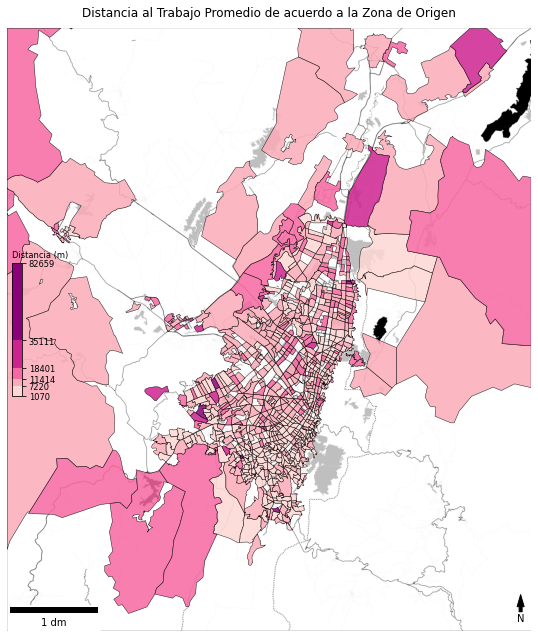

In [ ]:
from aves.visualization.maps import choropleth_map
grid = GeoFacetGrid(zonas_en_caja.join(distancia_zonas_mean, how="left"), height=9)
grid.add_basemap("bogota_toner_12.tif")
grid.add_layer(
    choropleth_map,
    "media_distancia_al_trabajo",
    k=5,
    linewidth=0.5,
    edgecolor="black",
    binning="fisher_jenks",
    palette="RdPu",
    alpha=0.85,
    cbar_args=dict(
        label="Distancia (m)",
        height="22%",
        width="2%",
        orientation="vertical",
        location="center left",
        label_size="small",
        bbox_to_anchor=(0.0, 0.0, 0.9, 1.0),
    ),
)
grid.add_map_elements()
grid.set_title("Distancia al Trabajo Promedio de acuerdo a la Zona de Origen")
grid.tight_layout()

In [ ]:
matriz_zonas = (viajes_trabajo[(viajes_trabajo['zat_origen'] != viajes_trabajo['zat_destino'])
                            & (viajes_trabajo.DIA_HABIL=='Si')
                             & (viajes_trabajo['zat_origen'].isin(zonas_en_caja.ZAT))
                             & (viajes_trabajo['zat_origen'].isin(zonas_en_caja.ZAT))]
                    .groupby(['zat_origen', 'zat_destino'])
                    .agg(n_viajes=('f_exp_x', 'sum'))
                    .sort_values('n_viajes', ascending=False)
                    .assign(cumsum_viajes=lambda x: x['n_viajes'].cumsum())
                    .assign(cumsum_viajes=lambda x: x['cumsum_viajes'] / x['cumsum_viajes'].max())
                    .reset_index()
)
matriz_zonas.to_csv(data_path + '/matriz_zonas_trabajo_bogota2019.csv', index=False)

In [ ]:
matriz_zonas = (viajes_total[(viajes_total['zat_origen'] != viajes_total['zat_destino'])
                             & (viajes_total['zat_origen'].isin(zonas_en_caja.ZAT))
                             & (viajes_total['zat_origen'].isin(zonas_en_caja.ZAT))]
                    .groupby(['zat_origen', 'zat_destino'])
                    .agg(n_viajes=('f_exp_x', 'sum'))
                    .sort_values('n_viajes', ascending=False)
                    .assign(cumsum_viajes=lambda x: x['n_viajes'].cumsum())
                    .assign(cumsum_viajes=lambda x: x['cumsum_viajes'] / x['cumsum_viajes'].max())
                    .reset_index()
)
matriz_zonas.to_csv(data_path + '/matriz_zonas_todos_bogota2019.csv', index=False)

In [ ]:
matriz_zonas = (viajes_habiles[(viajes_habiles['zat_origen'] != viajes_habiles['zat_destino'])
                             & (viajes_habiles['zat_origen'].isin(zonas_en_caja.ZAT))
                             & (viajes_habiles['zat_origen'].isin(zonas_en_caja.ZAT))]
                    .groupby(['zat_origen', 'zat_destino'])
                    .agg(n_viajes=('f_exp_x', 'sum'))
                    .sort_values('n_viajes', ascending=False)
                    .assign(cumsum_viajes=lambda x: x['n_viajes'].cumsum())
                    .assign(cumsum_viajes=lambda x: x['cumsum_viajes'] / x['cumsum_viajes'].max())
                    .reset_index()
)
matriz_zonas.to_csv(data_path + '/matriz_zonas_habiles_bogota2019.csv', index=False)

In [ ]:
matriz_zonas = matriz_zonas[matriz_zonas['cumsum_viajes'] <= 0.5]

In [ ]:
matriz_zonas.shape

(3003, 4)

In [ ]:
merged_zones = zonas_en_caja.dissolve('ZAT')#.drop('id', axis=1)

In [ ]:
from aves.models.network import Network
from aves.visualization.networks import NodeLink

zone_od_network = Network.from_edgelist(
    matriz_zonas, source="zat_origen", target="zat_destino", weight="n_viajes"
)

In [ ]:
zone_nodelink = NodeLink(zone_od_network)
zone_nodelink.layout_nodes(method="geographical", geodataframe=merged_zones)
zone_nodelink.set_node_drawing("plain", weights=zone_od_network.node_degree("in"))
zone_nodelink.set_edge_drawing(method="origin-destination")

/usr/local/lib/python3.7/site-packages/aves/models/network/layouts.py:165: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  node_positions = positions_to_array(self.geodf.geometry.centroid)


In [ ]:
zone_nodelink.bundle_edges(
    method="force-directed", K=10, S=0.01, I=10, compatibility_threshold=0.65, C=6
)

In [ ]:
def plot_network(ax, geo_data, *args, **kwargs):
    zone_nodelink.plot(ax, *args, **kwargs)

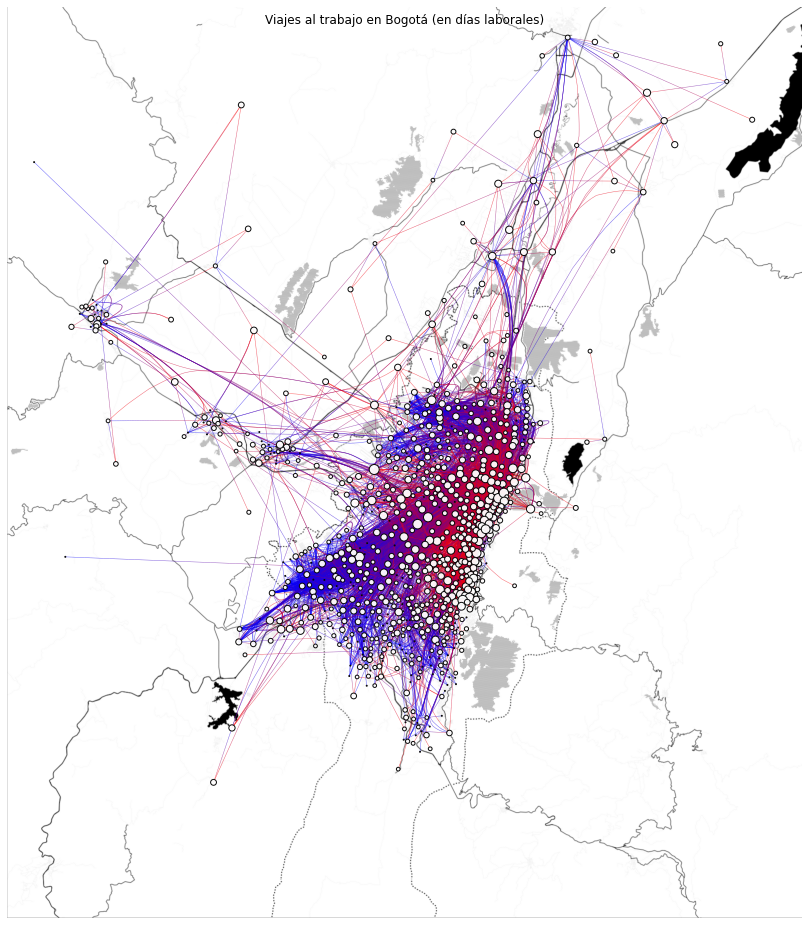

In [ ]:
grid = GeoFacetGrid(zonas_en_caja, height=13)
grid.add_basemap("bogota_toner_12.tif")
#grid.add_layer(city_shp_filt,facecolor='white', edgecolor='grey', alpha=0.25)
grid.add_layer(
    plot_network,
    nodes=dict(color="white", edgecolor="black", node_size=100, alpha=0.95),
    edges=dict(linewidth=0.5, alpha=0.6),
)
grid.set_title("Viajes al trabajo en Bogotá (en días laborales)")